In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import os
import math
#import metpy
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
import metpy.calc as mpcalc
from metpy.units import units
from functions_gapfill import *
import gstools as gs
import statsmodels.api as sm

ModuleNotFoundError: No module named 'yaml'

# Gapfilling the limnology data of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the post-processed selection of limnology data of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

We use already 3 hourly aggregated values of three platforms:

* The Thermister Chain (TChain from here onwards)

* The Thetis Multispectral thingy (Thetis from here onwards)

* The lake profiler Idronaut (Idronaut from here onwards)

and we fill gaps for the following variables on 3 hour resolution:

* Water temperature (Tchain, Thetis, Idronaut)

* Chlorophyll A (Thetis, Idronaut)

* Dissolved Oxygen (Thetis, Idronaut)

* Oxygen Saturation (Thetis, Idronaut)


on 38 levels for each data set. 

To do so, we use independent data as co-variates, namely the other two sensor platforms as well as simulated water temperature from https://www.alplakes.eawag.ch/.

## Activate G2S server

In [ ]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


In [ ]:
os.chdir("/home/mwegmann/")

In [ ]:
!bash -c "cd G2S/build/c++-build/ && ./g2s_server -d"


## folder setup

In [ ]:
# change yaml location here
with open(r"/home/mwegmann/gapfill/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

plots_folder=directories["g2s_plot_folder"]

recs_folder=directories["g2s_reconstructions_folder"]

scripts_folder=directories["scripts_folder"]

## read in postprocessed input data

check notebooks X and Y to see how this data was created.

### TChain

In [ ]:
tchain=xr.open_dataset(input_folder+"tchain_3hr_g2s.nc")

In [ ]:
tchain

### Thetis

In [ ]:
thetis=xr.open_dataset(input_folder+"thetis_3hr_g2s.nc")

In [ ]:
thetis

### Idronaut

In [ ]:
idronaut=xr.open_dataset(input_folder+"idronaut_3hr_g2s.nc")

In [ ]:
idronaut

### Lake Reanalysis

In [ ]:
meteolakes=xr.open_dataset(input_folder+"meteolakes_g2s.nc")

In [ ]:
meteolakes=meteolakes.sel(depth=tchain.depth.values,method="nearest")

In [ ]:
meteolakes

## define L3 boundaries

In [ ]:
time_resolution_hr=3

In [ ]:
timestepsinday=int(24/time_resolution_hr)

In [ ]:
max_day_gap=5

In [ ]:
max_timesteps_tofill=timestepsinday*max_day_gap
max_timesteps_tofill

## Fill Tchain Data

In [ ]:
varname="temp"


In [ ]:
tchain[varname].plot()

In [ ]:
gap_info(var=tchain[varname],varname="tchain_temp",plot_folder=plots_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[8,16,24]
selector_list=[1,2,3]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)



In [ ]:
filled_data,error_df=univ_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="linear")

In [ ]:
filled_data,error_df=univ_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="inverse")

In [ ]:
filled_data,error_df=univ_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="var")

In [ ]:
filled_data,error_df=day_of_year_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="var",vario=False)

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="var")

In [ ]:
filled_data,error_df=one_cov_g2s_2D(original=tchain,var1=varname,cov=meteolakes,var2="Temp",cov_name="model",obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,plot_folder=plots_folder,name="tchain_eval_",depan="var")

In [ ]:
filled_data,error_df=one_cov_g2s_2D(original=tchain,var1=varname,cov=thetis,var2="temp",cov_name="thetis",obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,plot_folder=plots_folder,name="tchain_eval_",depan="var")

In [ ]:
filled_data,error_df=one_cov_g2s_2D(original=tchain,var1=varname,cov=idronaut.transpose(),var2="temp",cov_name="idronaut",obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,plot_folder=plots_folder,name="tchain_eval_",depan="var")

#### error phase

In [ ]:
percent_list=[5,10,15]
gap_amount_list=[8,16,24,32,40,48]
selector_list=[1,2,3,4,5,6]
N = 25
test_runs=5

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","RMSE_VAR_mean","RMSE_VAR_median","RMSE_VAR_lin","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","VAR_pchip","RMSE_VAR_subdlin","STDR","DEPTH"]

df = pd.DataFrame(columns=columns_df)


In [ ]:
filled_data,error_df=day_of_year_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,plot_folder=plots_folder,name="tchain_season_",depan="var")


In [ ]:
#################

In [2]:
import pandas as pd

In [26]:
error_df=pd.read_csv("/Users/mwegmann/Dropbox/EPFL/tchain_season_temp.csv")


In [4]:
error_df

NAME  RUN  MEMBER  PERC  GAP_SIZE    CORR  CORR_lin  CORR_akima  \
0    caldayv    4      25     5         8  0.9988    0.9980      0.9978   
1    caldayv    4      25     5         8  0.9988    0.9980      0.9978   
2    caldayv    4      25     5         8  0.9988    0.9980      0.9978   
3    caldayv    4      25     5         8  0.9988    0.9980      0.9978   
4    caldayv    4      25     5         8  0.9988    0.9980      0.9978   
..       ...  ...     ...   ...       ...     ...       ...         ...   
589  caldayv    5      25    15        48  0.9910    0.9857      0.9568   
590  caldayv    5      25    15        48  0.9910    0.9857      0.9568   
591  caldayv    5      25    15        48  0.9910    0.9857      0.9568   
592  caldayv    5      25    15        48  0.9910    0.9857      0.9568   
593  caldayv    5      25    15        48  0.9910    0.9857      0.9568   

     CORR_spline  CORR_quad  ...  RMSE_VAR_mean  RMSE_VAR_median  \
0         0.9926     0.9959  ...         0.1141           0.1101   
1         0.9926     0.9959  ...         0.0747           0.0724   
2         0.9926     0.9959  ...         0.2870           0.2922   
3         0.9926     0.9959  ...         0.1079           0.1168   
4         0.9926     0.9959  ...         0.0830           0.0765   
..           ...        ...  ...            ...              ...   
589       0.9790     0.7880  ...         0.0784           0.0751   
590       0.9790     0.7880  ...         0.2338           0.2475   
591       0.9790     0.7880  ...         0.0731           0.0796   
592       0.9790     0.7880  ...         0.0834           0.0763   
593       0.9790     0.7880  ...         0.5030           0.4814   

     RMSE_VAR_lin  RMSE_VAR_akima  RMSE_VAR_spline  RMSE_VAR_quad  \
0          0.1224          0.1186           0.1581         0.1030   
1          0.0832          0.0706           0.0657         0.2362   
2          0.2734          0.3203           0.2375         0.6432   
3          0.0934          0.1323           0.0870         0.7129   
4          0.0622          0.0572           0.0916         0.0999   
..            ...             ...              ...            ...   
589        0.1316          0.1080           0.1143         0.4498   
590        0.1907          0.3641           0.1246         3.7842   
591        0.0469          0.6188           0.0732         3.8136   
592        0.0701          0.1337           0.0982         0.6258   
593        0.5296          0.5112           0.5381         0.2109   

        VAR_pchip  RMSE_VAR_subdlin    STDR  DEPTH  
0    5.197118e+05            0.1295  1.0000   -1.2  
1    8.190000e-02            0.0853  1.0000   -5.0  
2    2.817000e-01            0.2542  1.0000  -10.0  
3    1.007000e-01            0.0842  1.0000  -15.0  
4    3.729866e+06            0.0676  1.0000  -30.0  
..            ...               ...     ...    ...  
589  1.273000e-01            0.1141  1.0006   -5.0  
590  2.084000e-01            0.2112  1.0006  -10.0  
591  5.010000e-02            0.0759  1.0006  -15.0  
592  3.729866e+06            0.0715  1.0006  -30.0  
593  3.562788e+05            0.5337  1.0006  -48.0  

[594 rows x 29 columns]

In [5]:
error_df.where(error_df["DEPTH"]==-5)

NAME  RUN  MEMBER  PERC  GAP_SIZE    CORR  CORR_lin  CORR_akima  \
0        NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
1    caldayv  4.0    25.0   5.0       8.0  0.9988    0.9980      0.9978   
2        NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
3        NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
4        NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
..       ...  ...     ...   ...       ...     ...       ...         ...   
589  caldayv  5.0    25.0  15.0      48.0  0.9910    0.9857      0.9568   
590      NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
591      NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
592      NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   
593      NaN  NaN     NaN   NaN       NaN     NaN       NaN         NaN   

     CORR_spline  CORR_quad  ...  RMSE_VAR_mean  RMSE_VAR_median  \
0            NaN        NaN  ...            NaN              NaN   
1         0.9926     0.9959  ...         0.0747           0.0724   
2            NaN        NaN  ...            NaN              NaN   
3            NaN        NaN  ...            NaN              NaN   
4            NaN        NaN  ...            NaN              NaN   
..           ...        ...  ...            ...              ...   
589       0.9790     0.7880  ...         0.0784           0.0751   
590          NaN        NaN  ...            NaN              NaN   
591          NaN        NaN  ...            NaN              NaN   
592          NaN        NaN  ...            NaN              NaN   
593          NaN        NaN  ...            NaN              NaN   

     RMSE_VAR_lin  RMSE_VAR_akima  RMSE_VAR_spline  RMSE_VAR_quad  VAR_pchip  \
0             NaN             NaN              NaN            NaN        NaN   
1          0.0832          0.0706           0.0657         0.2362     0.0819   
2             NaN             NaN              NaN            NaN        NaN   
3             NaN             NaN              NaN            NaN        NaN   
4             NaN             NaN              NaN            NaN        NaN   
..            ...             ...              ...            ...        ...   
589        0.1316          0.1080           0.1143         0.4498     0.1273   
590           NaN             NaN              NaN            NaN        NaN   
591           NaN             NaN              NaN            NaN        NaN   
592           NaN             NaN              NaN            NaN        NaN   
593           NaN             NaN              NaN            NaN        NaN   

     RMSE_VAR_subdlin    STDR  DEPTH  
0                 NaN     NaN    NaN  
1              0.0853  1.0000   -5.0  
2                 NaN     NaN    NaN  
3                 NaN     NaN    NaN  
4                 NaN     NaN    NaN  
..                ...     ...    ...  
589            0.1141  1.0006   -5.0  
590               NaN     NaN    NaN  
591               NaN     NaN    NaN  
592               NaN     NaN    NaN  
593               NaN     NaN    NaN  

[594 rows x 29 columns]

In [6]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC","DEPTH"]).mean()

RUN  MEMBER      CORR  CORR_lin  CORR_akima  \
GAP_SIZE PERC DEPTH                                                     
8        5    -48.0  3.166667    25.0  0.998717  0.998017    0.997667   
              -30.0  3.166667    25.0  0.998717  0.998017    0.997667   
              -15.0  3.166667    25.0  0.998717  0.998017    0.997667   
              -10.0  3.166667    25.0  0.998717  0.998017    0.997667   
              -5.0   3.166667    25.0  0.998717  0.998017    0.997667   
...                       ...     ...       ...       ...         ...   
48       15   -30.0  3.000000    25.0  0.991960  0.986020    0.958460   
              -15.0  3.000000    25.0  0.991960  0.986020    0.958460   
              -10.0  3.000000    25.0  0.991960  0.986020    0.958460   
              -5.0   3.000000    25.0  0.991960  0.986020    0.958460   
              -1.2   3.000000    25.0  0.991960  0.986020    0.958460   

                     CORR_spline  CORR_quad  CORR_pchip  CORR_subdlin  \
GAP_SIZE PERC DEPTH                                                     
8        5    -48.0     0.992283   0.995233    0.997983      0.996017   
              -30.0     0.992283   0.995233    0.997983      0.996017   
              -15.0     0.992283   0.995233    0.997983      0.996017   
              -10.0     0.992283   0.995233    0.997983      0.996017   
              -5.0      0.992283   0.995233    0.997983      0.996017   
...                          ...        ...         ...           ...   
48       15   -30.0     0.978160   0.810920    0.969680      0.985000   
              -15.0     0.978160   0.810920    0.969680      0.985000   
              -10.0     0.978160   0.810920    0.969680      0.985000   
              -5.0      0.978160   0.810920    0.969680      0.985000   
              -1.2      0.978160   0.810920    0.969680      0.985000   

                        RMSE  ...  RMSE_subdlin  RMSE_VAR_mean  \
GAP_SIZE PERC DEPTH           ...                                
8        5    -48.0  0.10245  ...      0.202933       0.508883   
              -30.0  0.10245  ...      0.202933       0.080883   
              -15.0  0.10245  ...      0.202933       0.111467   
              -10.0  0.10245  ...      0.202933       0.285050   
              -5.0   0.10245  ...      0.202933       0.075767   
...                      ...  ...           ...            ...   
48       15   -30.0  0.22432  ...      0.423060       0.096440   
              -15.0  0.22432  ...      0.423060       0.082620   
              -10.0  0.22432  ...      0.423060       0.234160   
              -5.0   0.22432  ...      0.423060       0.083420   
              -1.2   0.22432  ...      0.423060       0.121020   

                     RMSE_VAR_median  RMSE_VAR_lin  RMSE_VAR_akima  \
GAP_SIZE PERC DEPTH                                                  
8        5    -48.0         0.498967      0.524350        0.516017   
              -30.0         0.076967      0.060750        0.059317   
              -15.0         0.117450      0.104150        0.146200   
              -10.0         0.291617      0.267250        0.318250   
              -5.0          0.072900      0.085917        0.071133   
...                              ...           ...             ...   
48       15   -30.0         0.087020      0.099680        0.198120   
              -15.0         0.090000      0.062180        0.331660   
              -10.0         0.247980      0.164480        0.572000   
              -5.0          0.078420      0.141980        0.125040   
              -1.2          0.117240      0.167800        0.188320   

                     RMSE_VAR_spline  RMSE_VAR_quad     VAR_pchip  \
GAP_SIZE PERC DEPTH                                                 
8        5    -48.0         0.533117       0.442200  3.562788e+05   
              -30.0         0.080733       0.077950  3.729866e+06   
              -15.0         0.092450       0.704217  1.143667e-01   
           

In [7]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

RUN  MEMBER      CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE PERC                                                                  
8        5     3.166667    25.0  0.998717  0.998017    0.997667     0.992283   
         10    2.666667    25.0  0.997200  0.996150    0.995500     0.984400   
         15    3.000000    25.0  0.995220  0.994060    0.992880     0.976480   
16       5     3.166667    25.0  0.998417  0.996650    0.995617     0.992000   
         10    2.666667    25.0  0.996533  0.993700    0.991617     0.983900   
         15    3.000000    25.0  0.994400  0.990520    0.987560     0.976040   
24       5     3.166667    25.0  0.998283  0.996300    0.994167     0.992417   
         10    2.666667    25.0  0.995950  0.992283    0.987817     0.983517   
         15    3.000000    25.0  0.994000  0.989400    0.982860     0.976980   
32       5     3.166667    25.0  0.998000  0.995567    0.991283     0.992050   
         10    2.666667    25.0  0.995817  0.992017    0.984533     0.984267   
         15    3.000000    25.0  0.992640  0.986380    0.972440     0.974100   
40       5     3.166667    25.0  0.998133  0.996067    0.990783     0.992633   
         10    2.200000    25.0  0.994840  0.990500    0.977200     0.983140   
         15    3.000000    25.0  0.992780  0.986720    0.969540     0.976200   
48       5     3.000000    25.0  0.997580  0.995440    0.989160     0.992300   
         10    2.200000    25.0  0.994600  0.990540    0.975600     0.982640   
         15    3.000000    25.0  0.991960  0.986020    0.958460     0.978160   

               CORR_quad  CORR_pchip  CORR_subdlin      RMSE  ...  \
GAP_SIZE PERC                                                 ...   
8        5      0.995233    0.997983      0.996017  0.102450  ...   
         10     0.990700    0.996050      0.992083  0.151833  ...   
         15     0.985080    0.993800      0.987960  0.199600  ...   
16       5      0.987100    0.996467      0.995267  0.107033  ...   
         10     0.973000    0.993433      0.990833  0.157733  ...   
         15     0.959480    0.990180      0.985940  0.207760  ...   
24       5      0.976133    0.996100      0.995233  0.108300  ...   
         10     0.955600    0.991800      0.989983  0.165217  ...   
         15     0.934880    0.988800      0.985920  0.215480  ...   
32       5      0.959550    0.995233      0.994767  0.113700  ...   
         10     0.933067    0.991500      0.990467  0.166317  ...   
         15     0.878160    0.985660      0.983380  0.215660  ...   
40       5      0.953767    0.995800      0.995350  0.114717  ...   
         10     0.886240    0.990000      0.989200  0.176300  ...   
         15     0.831040    0.985860      0.985220  0.218940  ...   
48       5      0.932020    0.995100      0.994560  0.116160  ...   
         10     0.862640    0.989880      0.988840  0.173840  ...   
         15     0.810920    0.969680      0.985000  0.224320  ...   

               RMSE_VAR_mean  RMSE_VAR_median  RMSE_VAR_lin  RMSE_VAR_akima  \
GAP_SIZE PERC                                                                 
8        5          0.196283         0.195003      0.194314        0.204528   
         10         0.193931         0.193539      0.192889        0.207194   
         15         0.191163         0.190797      0.190667        0.204617   
16       5          0.196108         0.194492      0.194900        0.207233   
         10         0.193375         0.192506      0.193031        0.208958   
         15         0.191507         0.190567      0.191060        0.218440   
24       5          0.194900         0.193875      0.191500        0.211458   
         10         0.192328         0.190625      0.189792        0.220222   
         15         0.189873         0.189540      0.191733        0.252650   
32       5          0.197683         0.196167      0.195544        0.214933   
         10         0.193397         0.191892      0.195117        0.231083   
         15

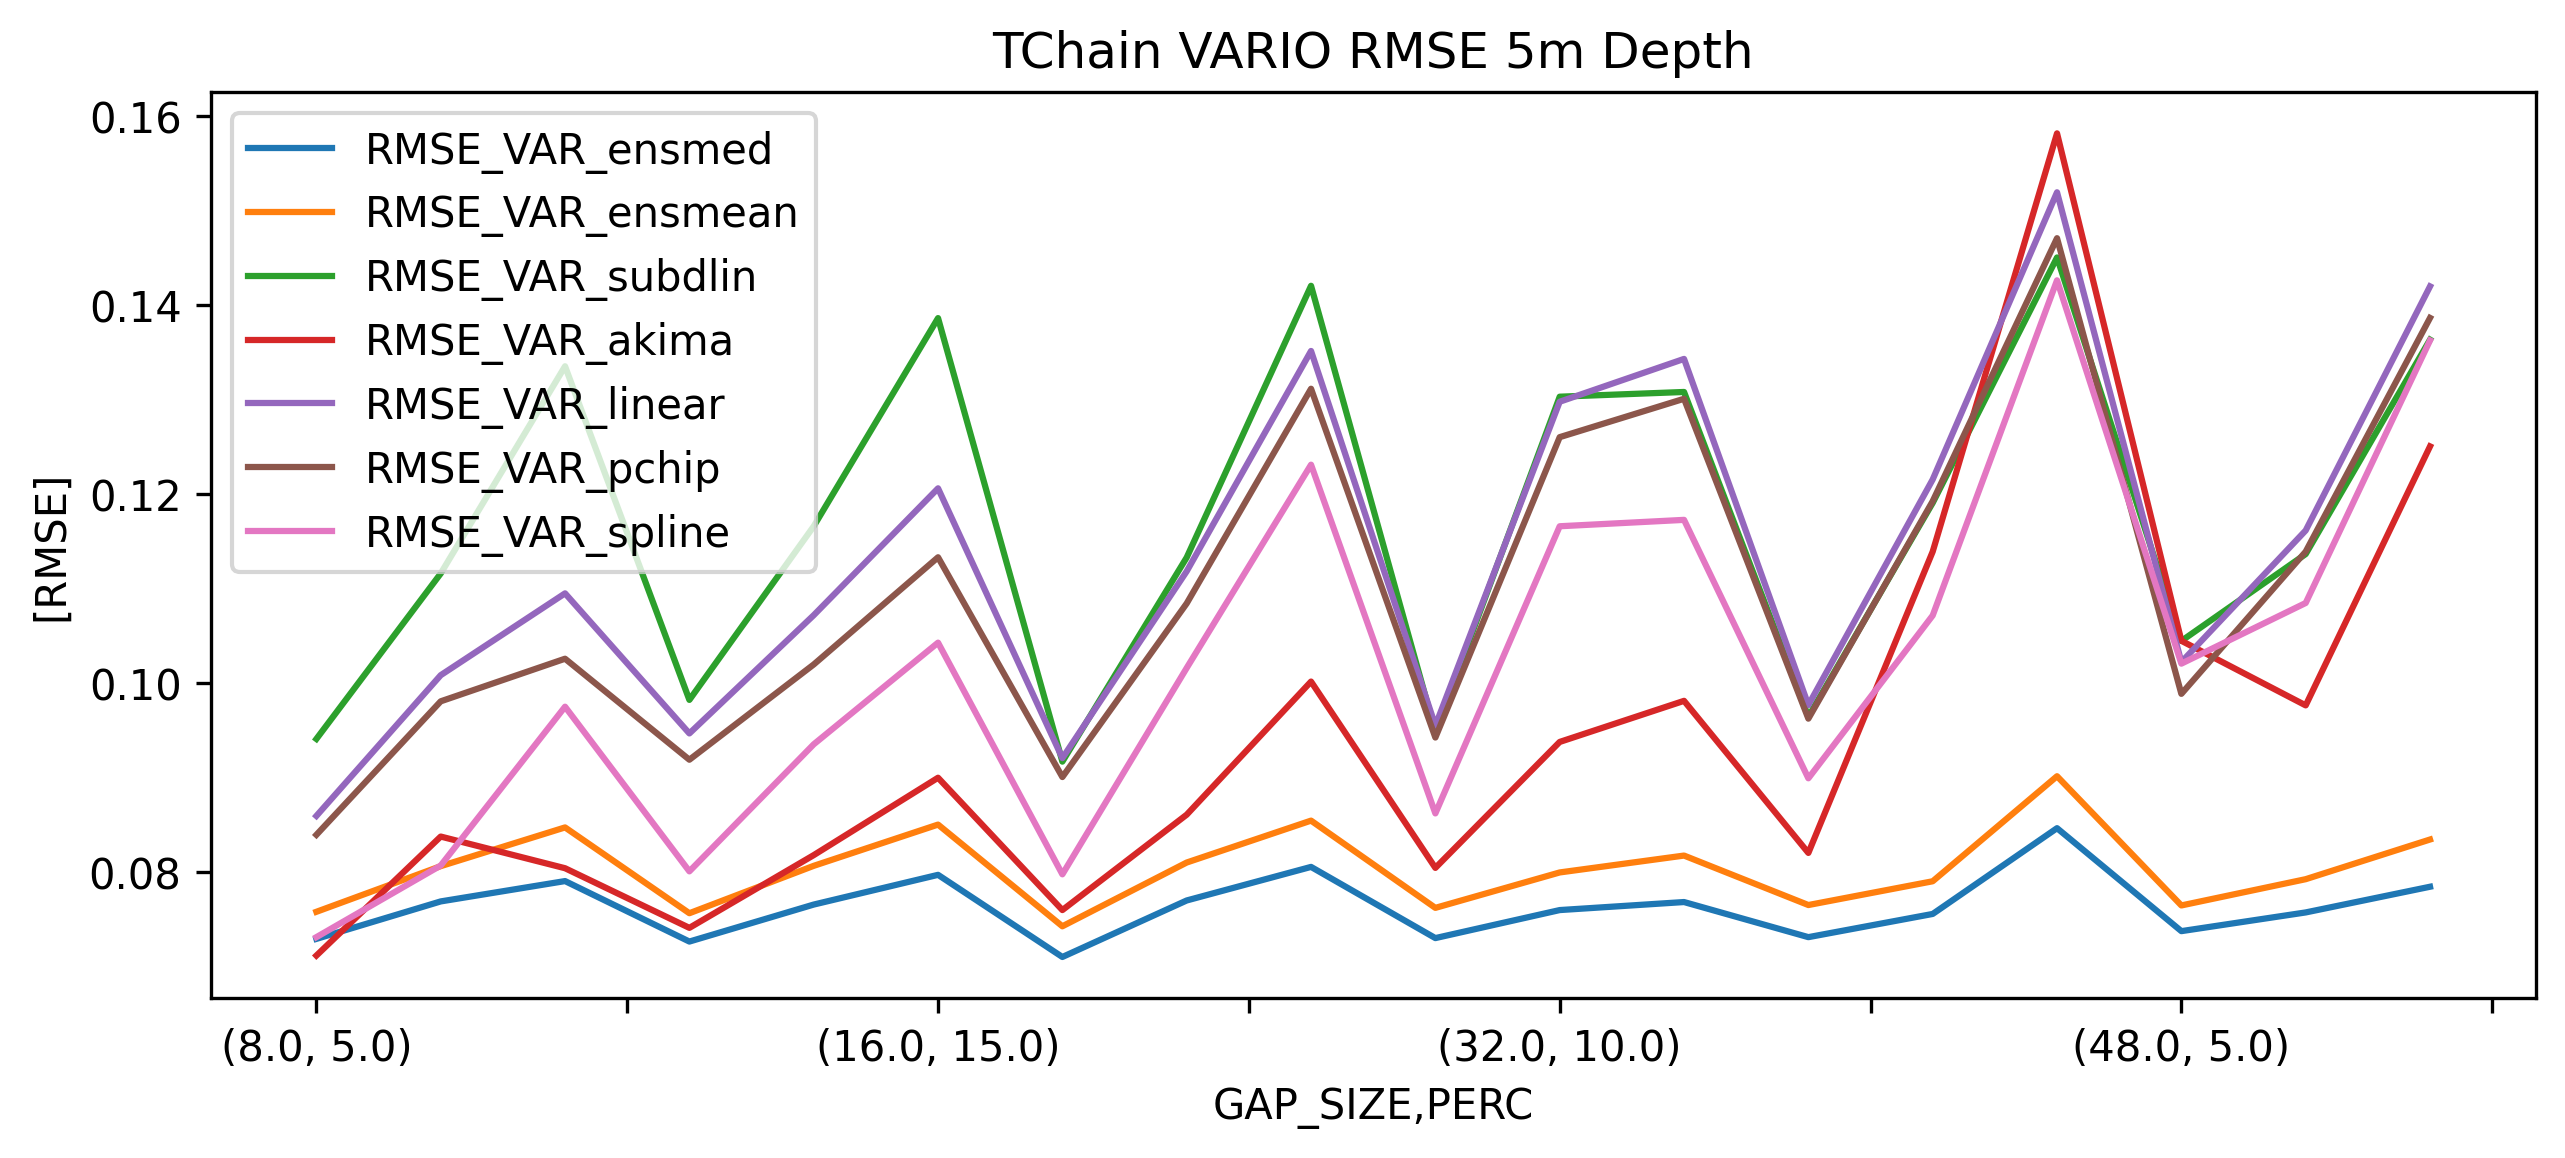

In [9]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-5).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")


plt.legend()
name="TChain VARIO RMSE 5m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE5.png")

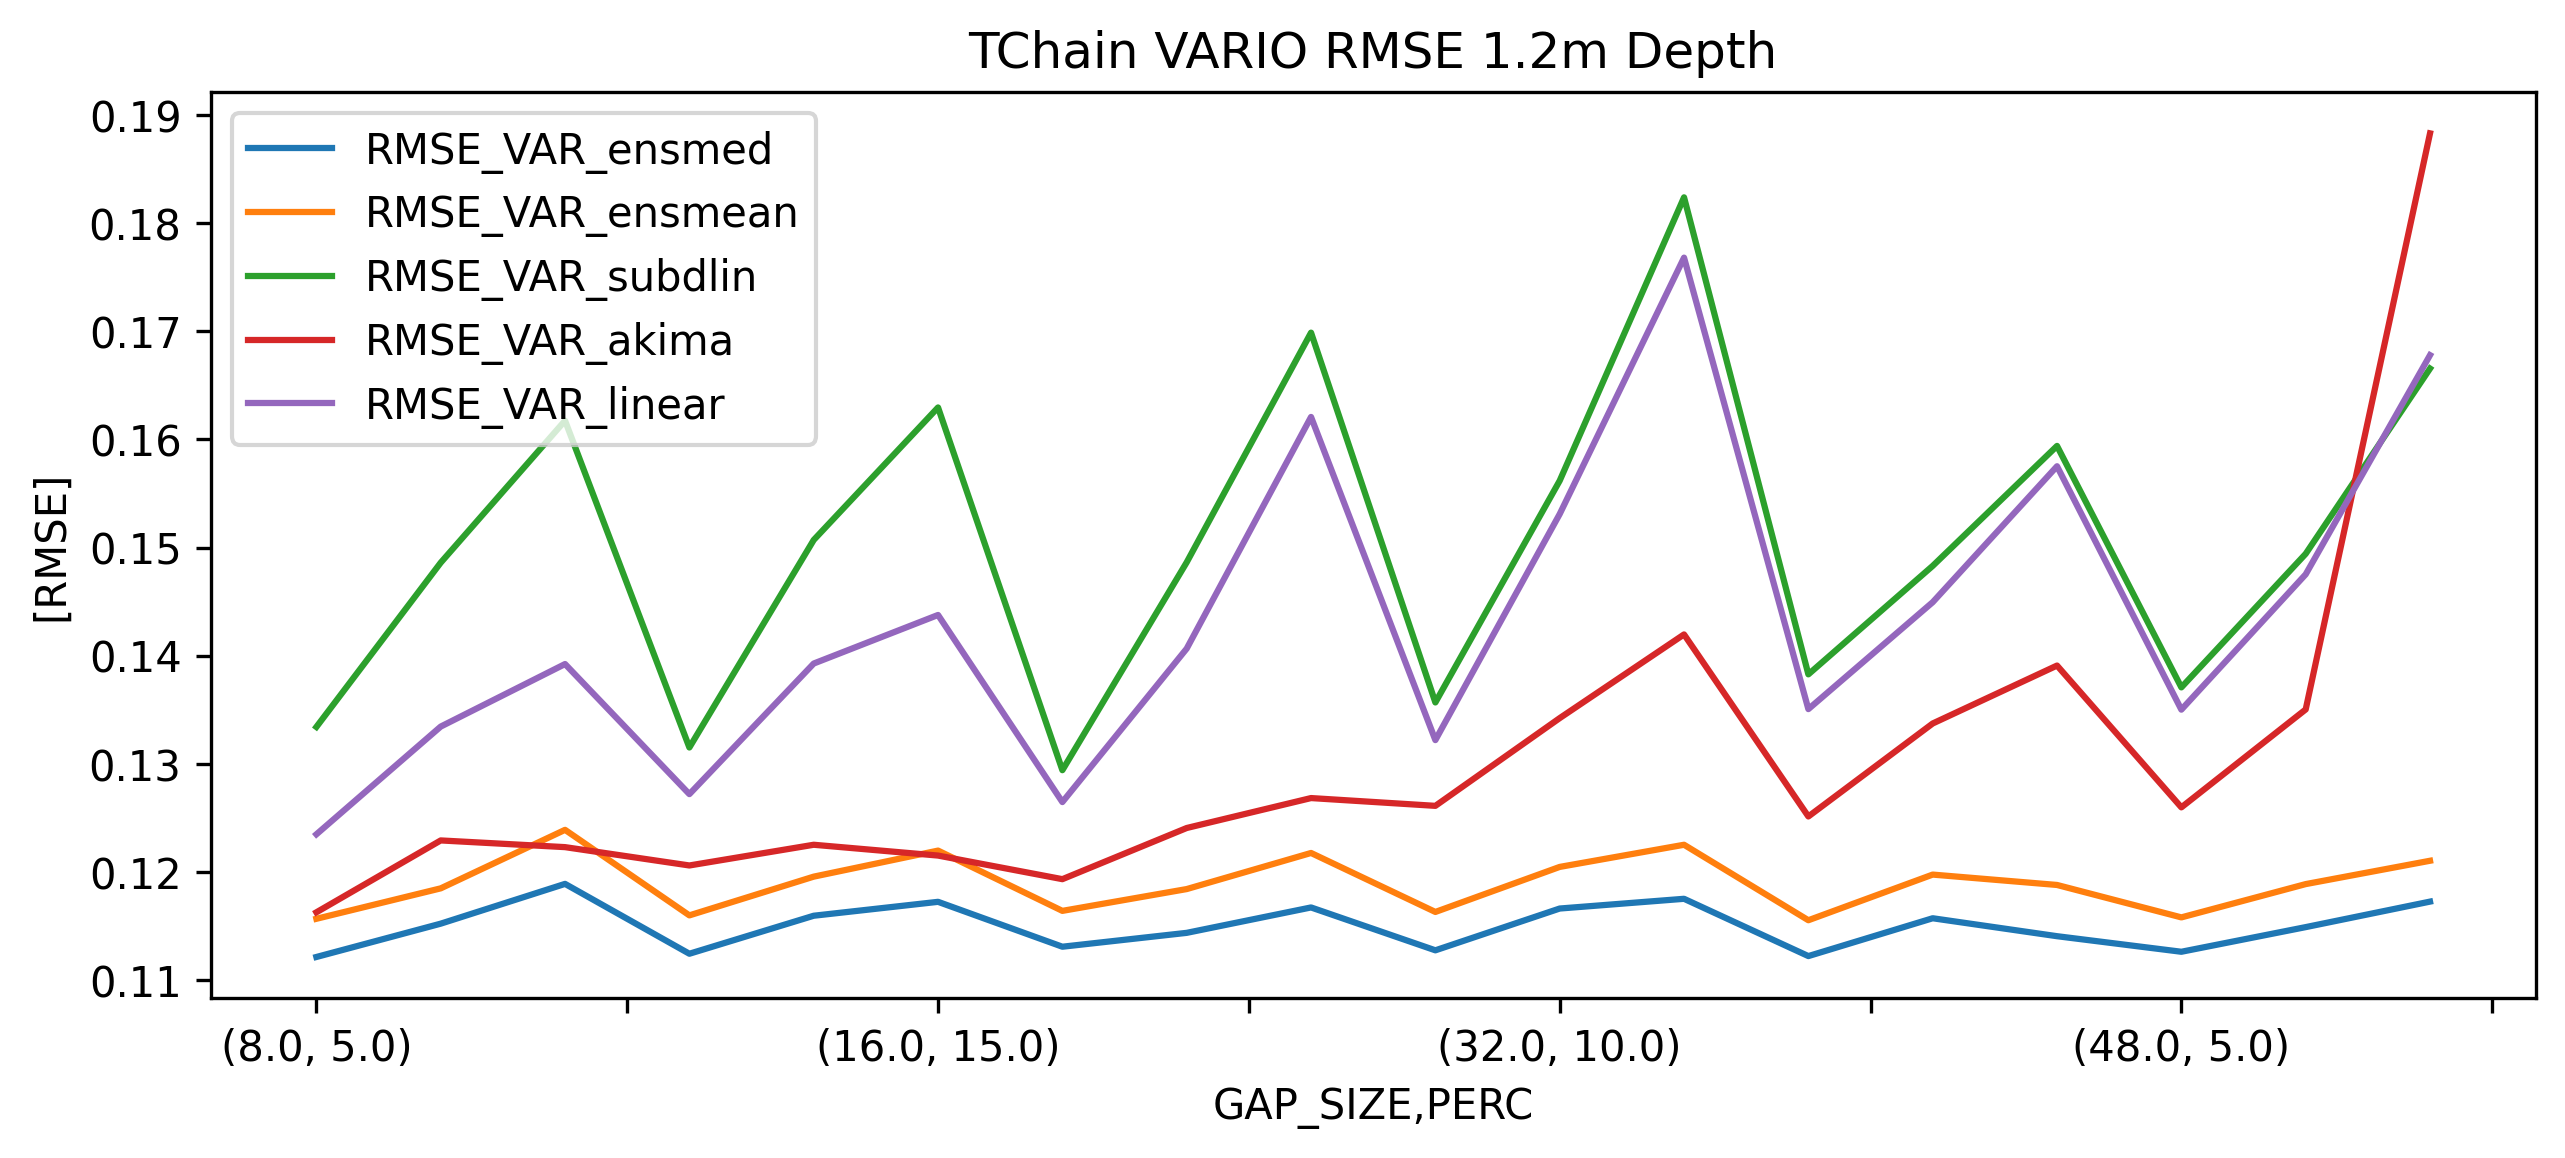

In [12]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
#error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-1.2).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")


plt.legend()
name="TChain VARIO RMSE 1.2m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE12.png")

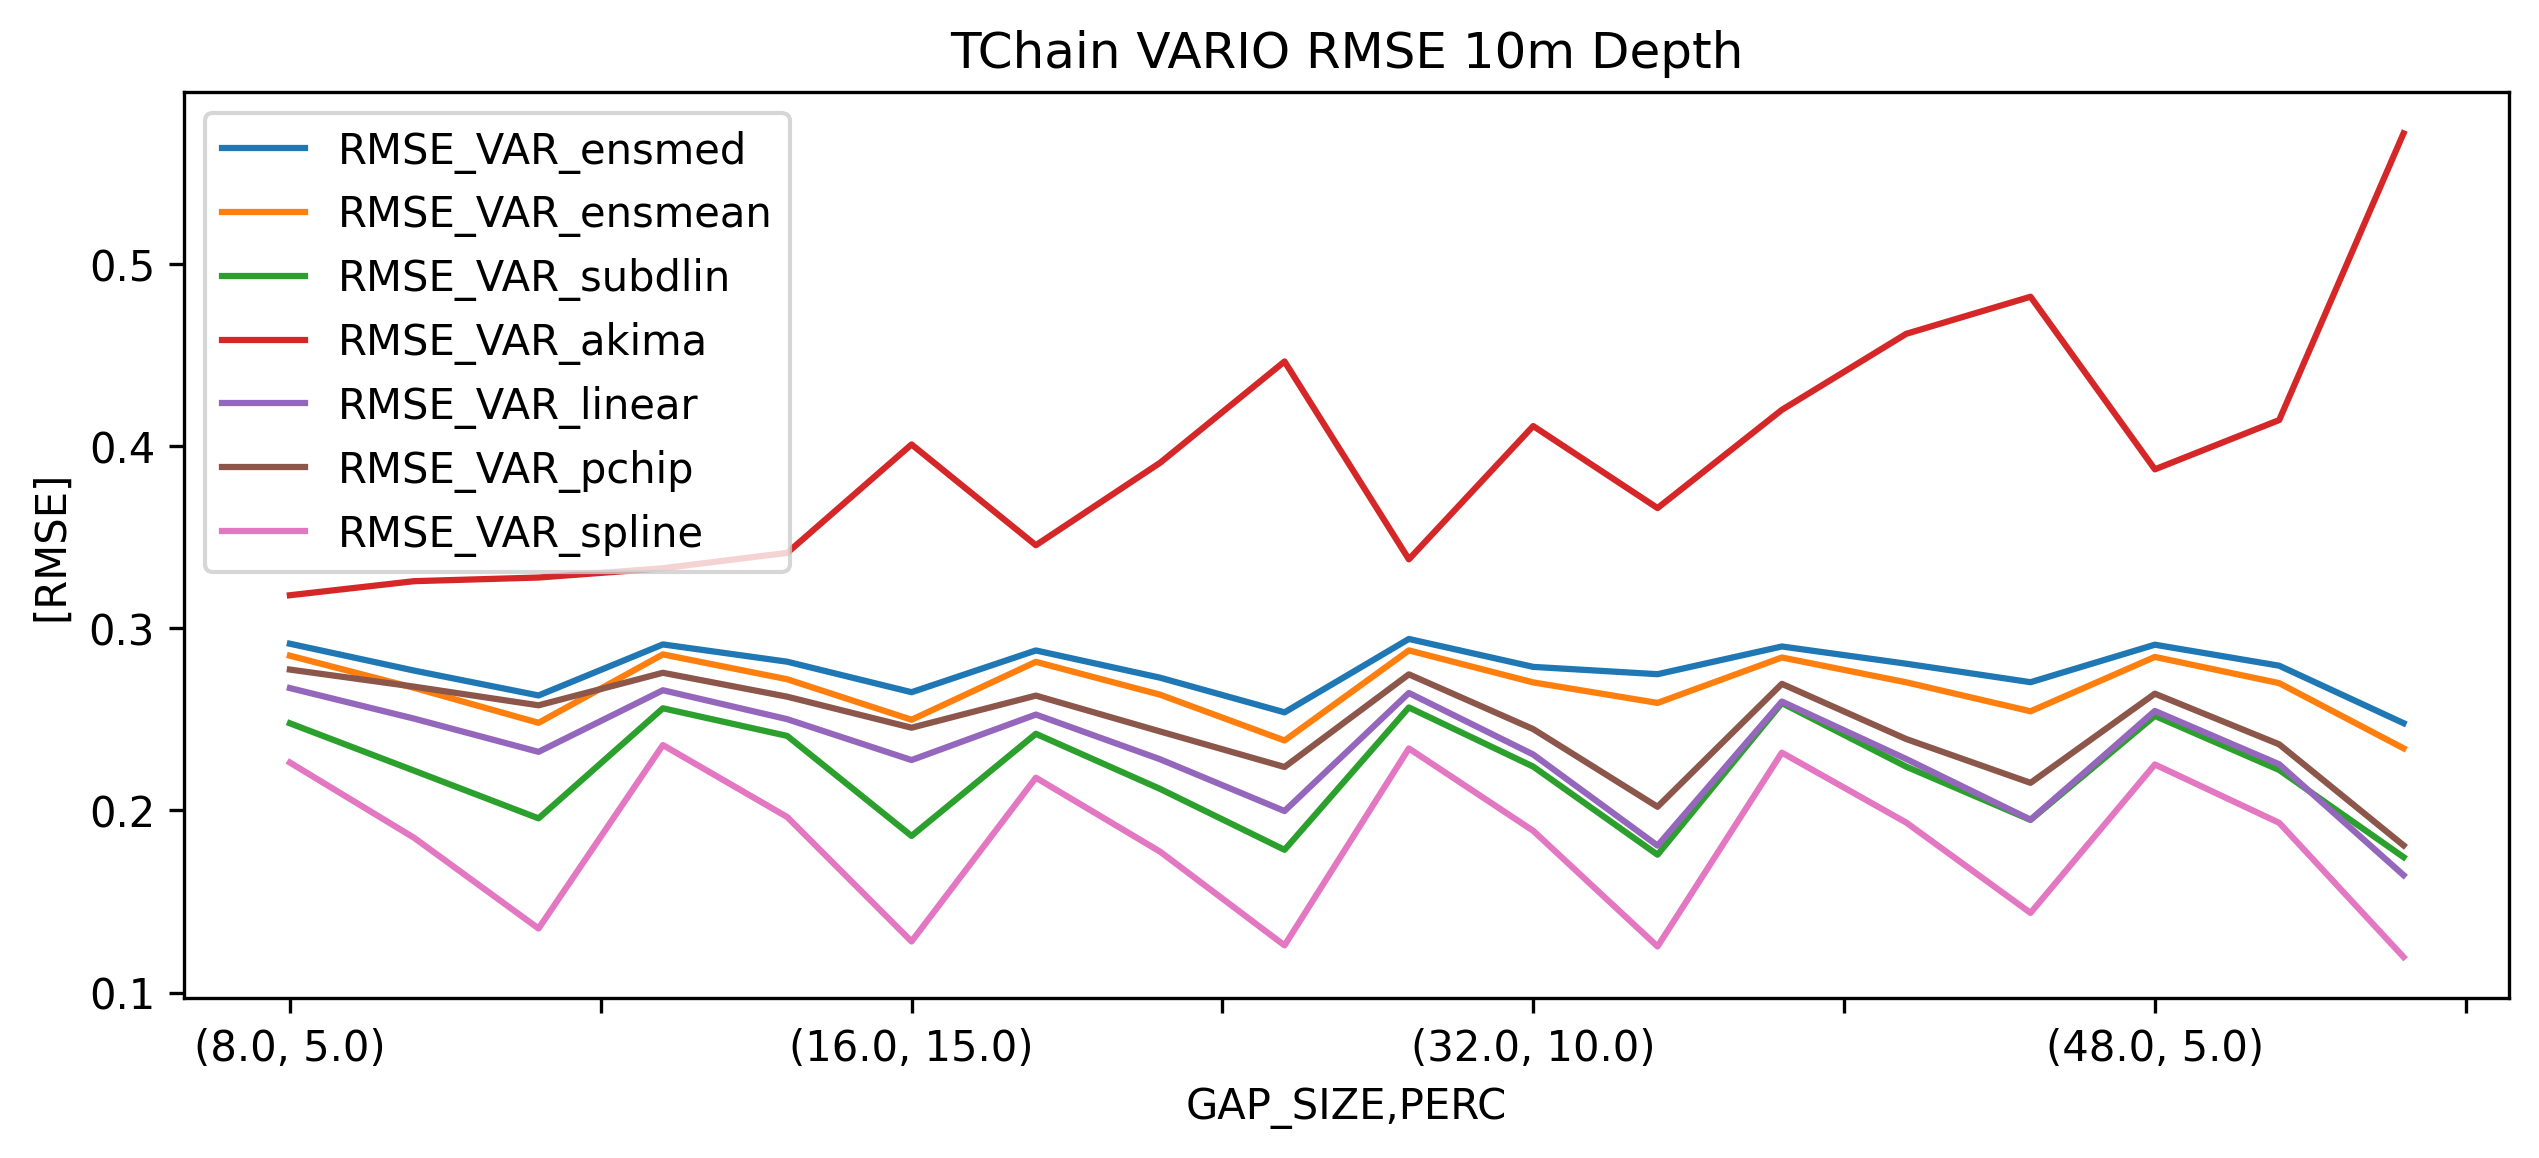

In [13]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-10).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")


plt.legend()
name="TChain VARIO RMSE 10m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE10.png")

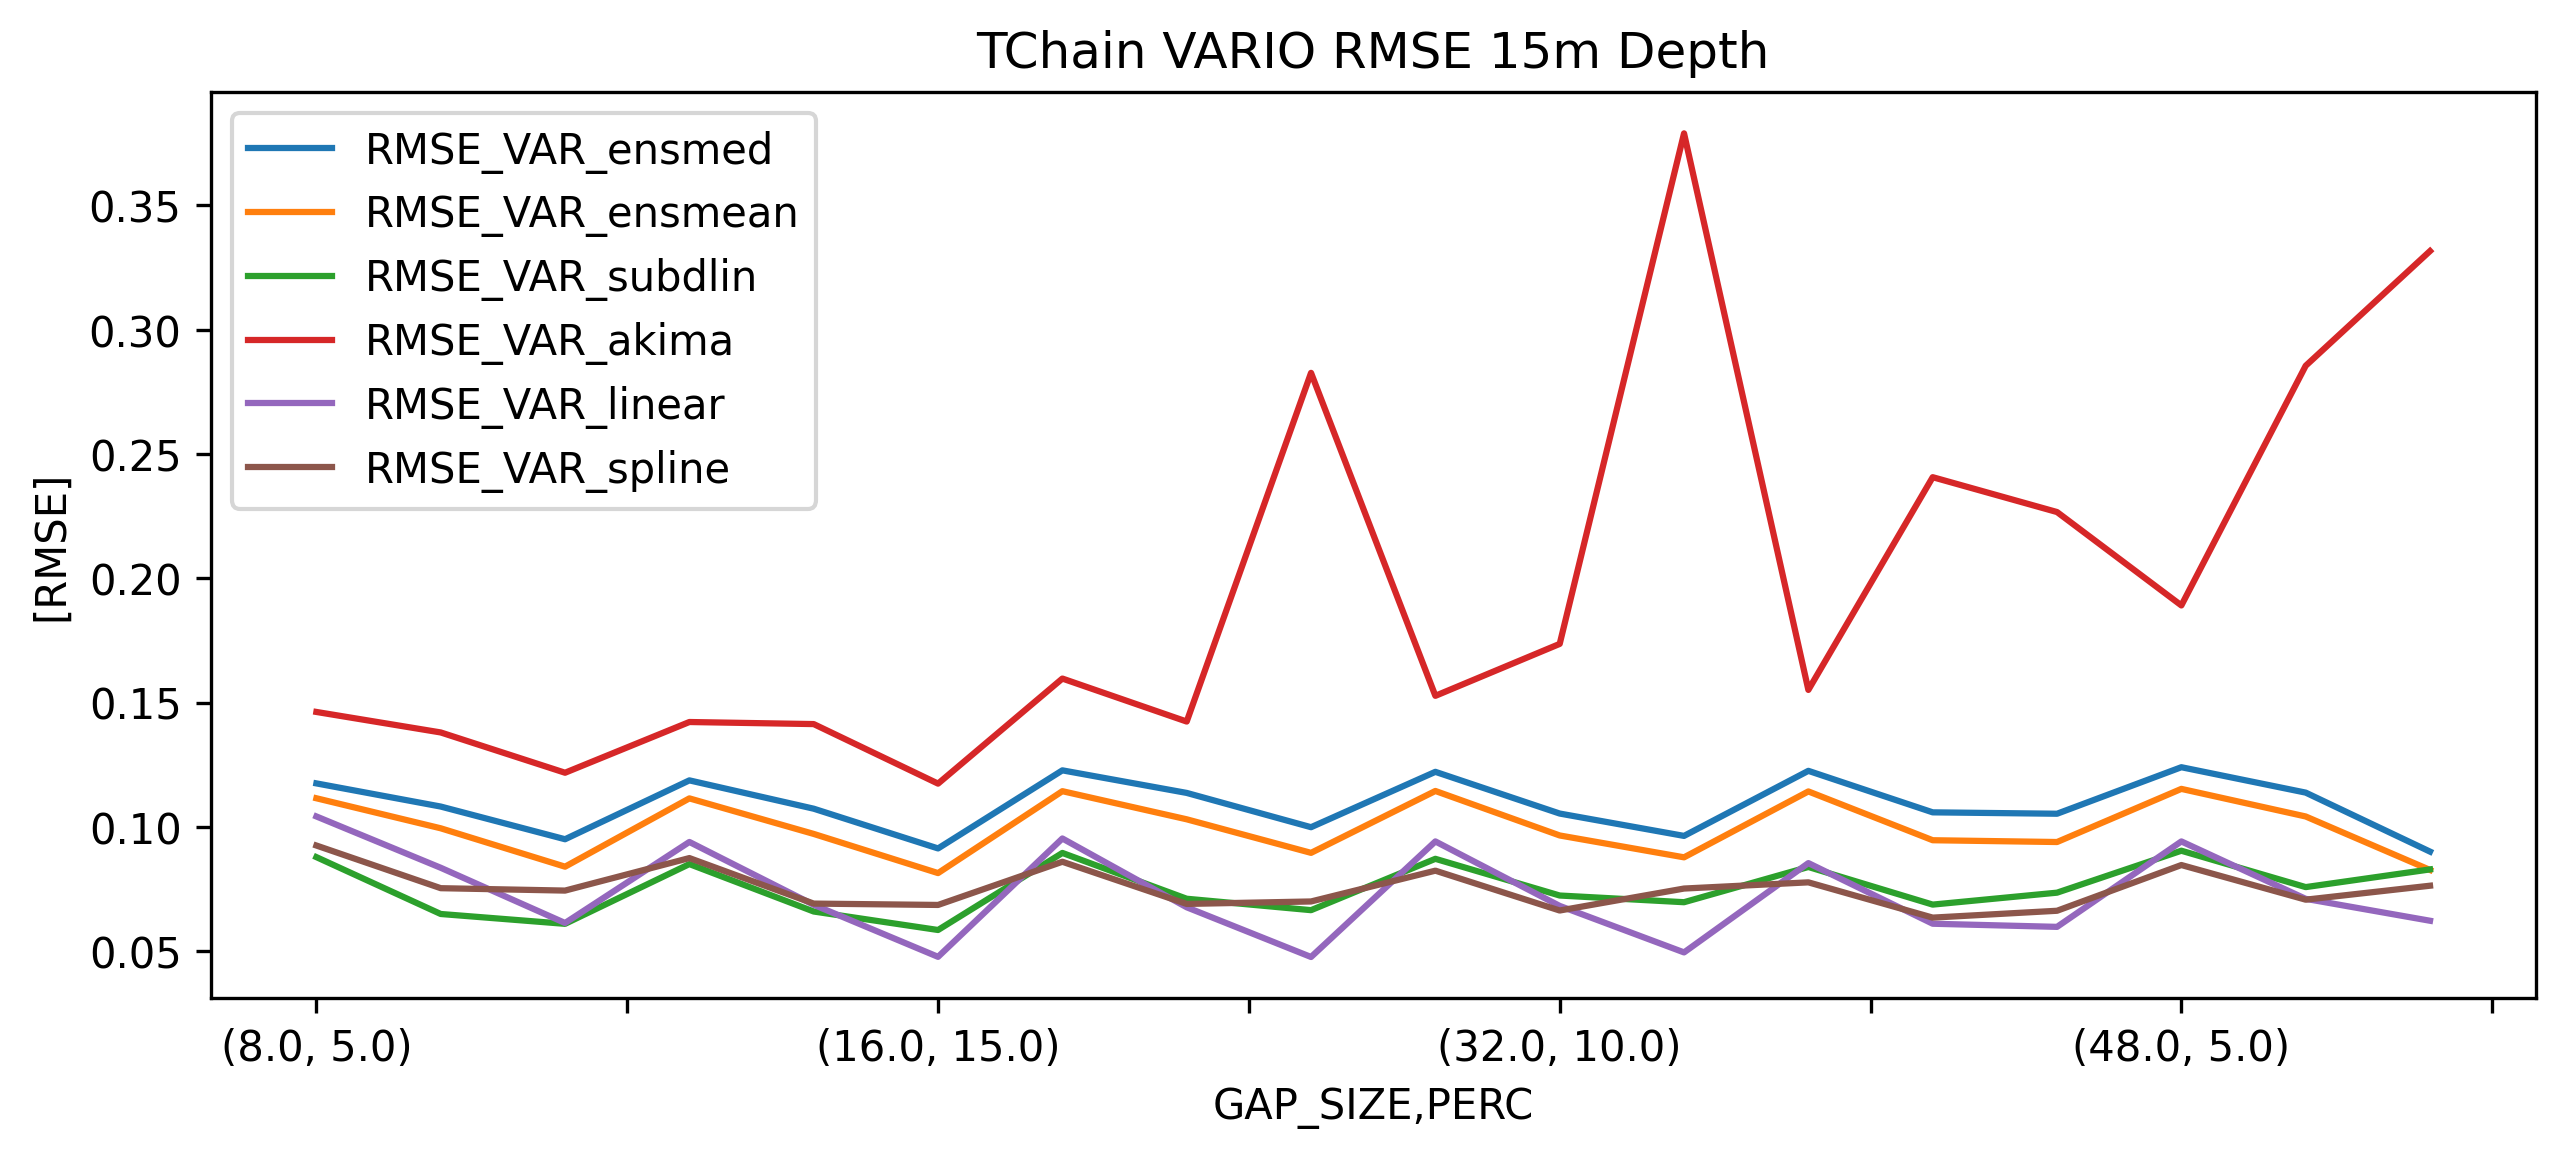

In [14]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
#error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-15).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")



plt.legend()
name="TChain VARIO RMSE 15m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE15.png")


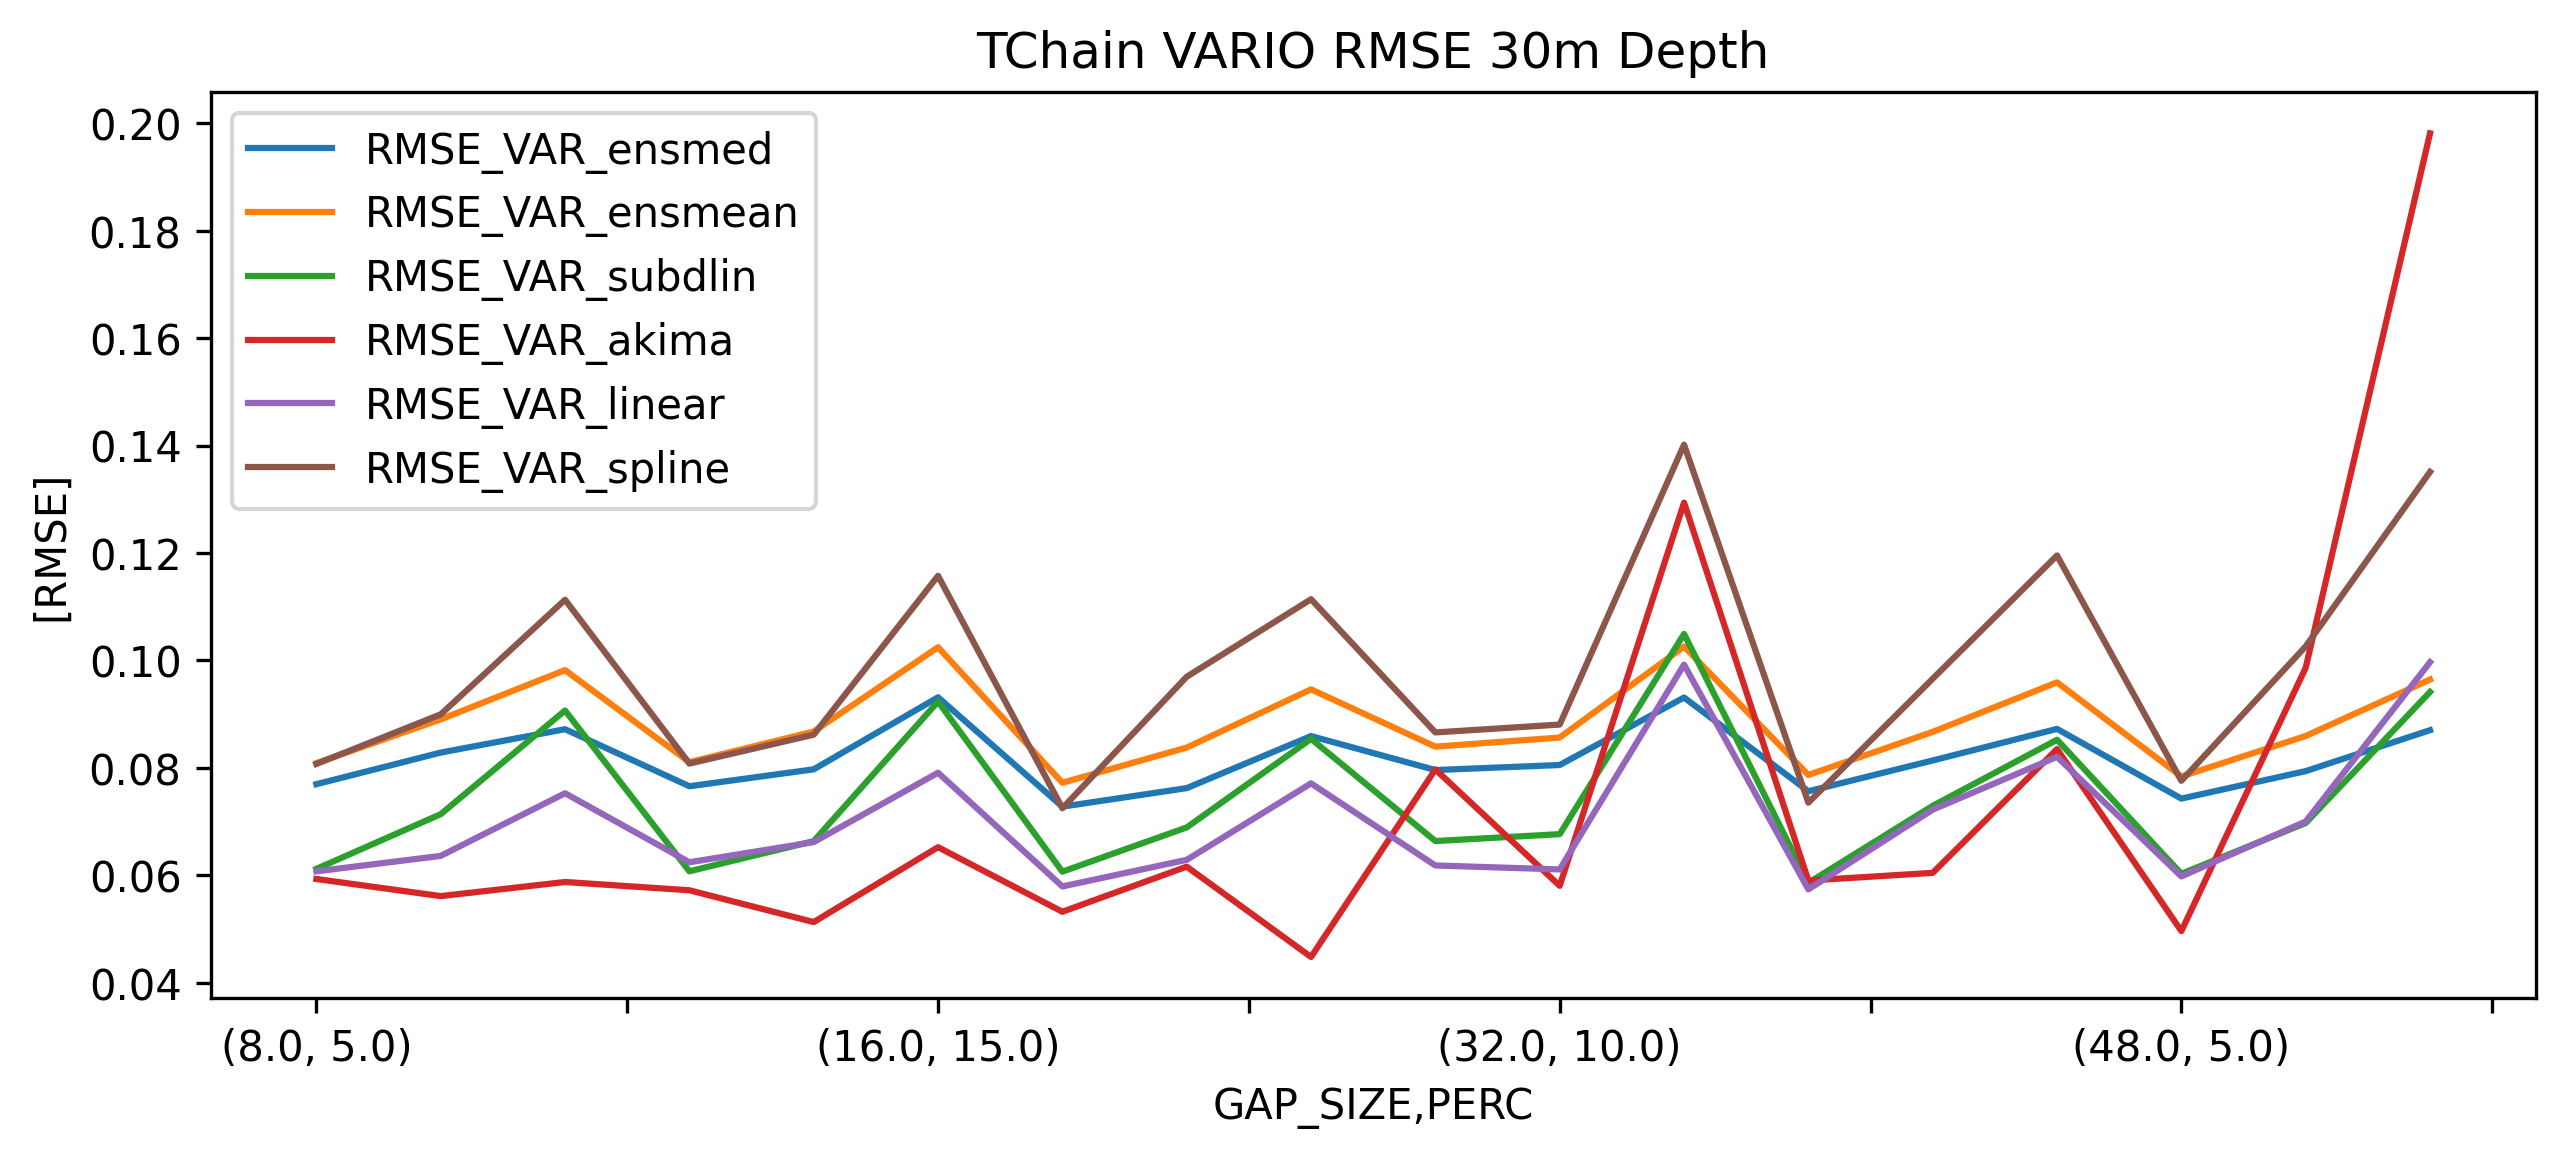

In [15]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
#error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-30).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")


plt.legend()
name="TChain VARIO RMSE 30m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE30.png")

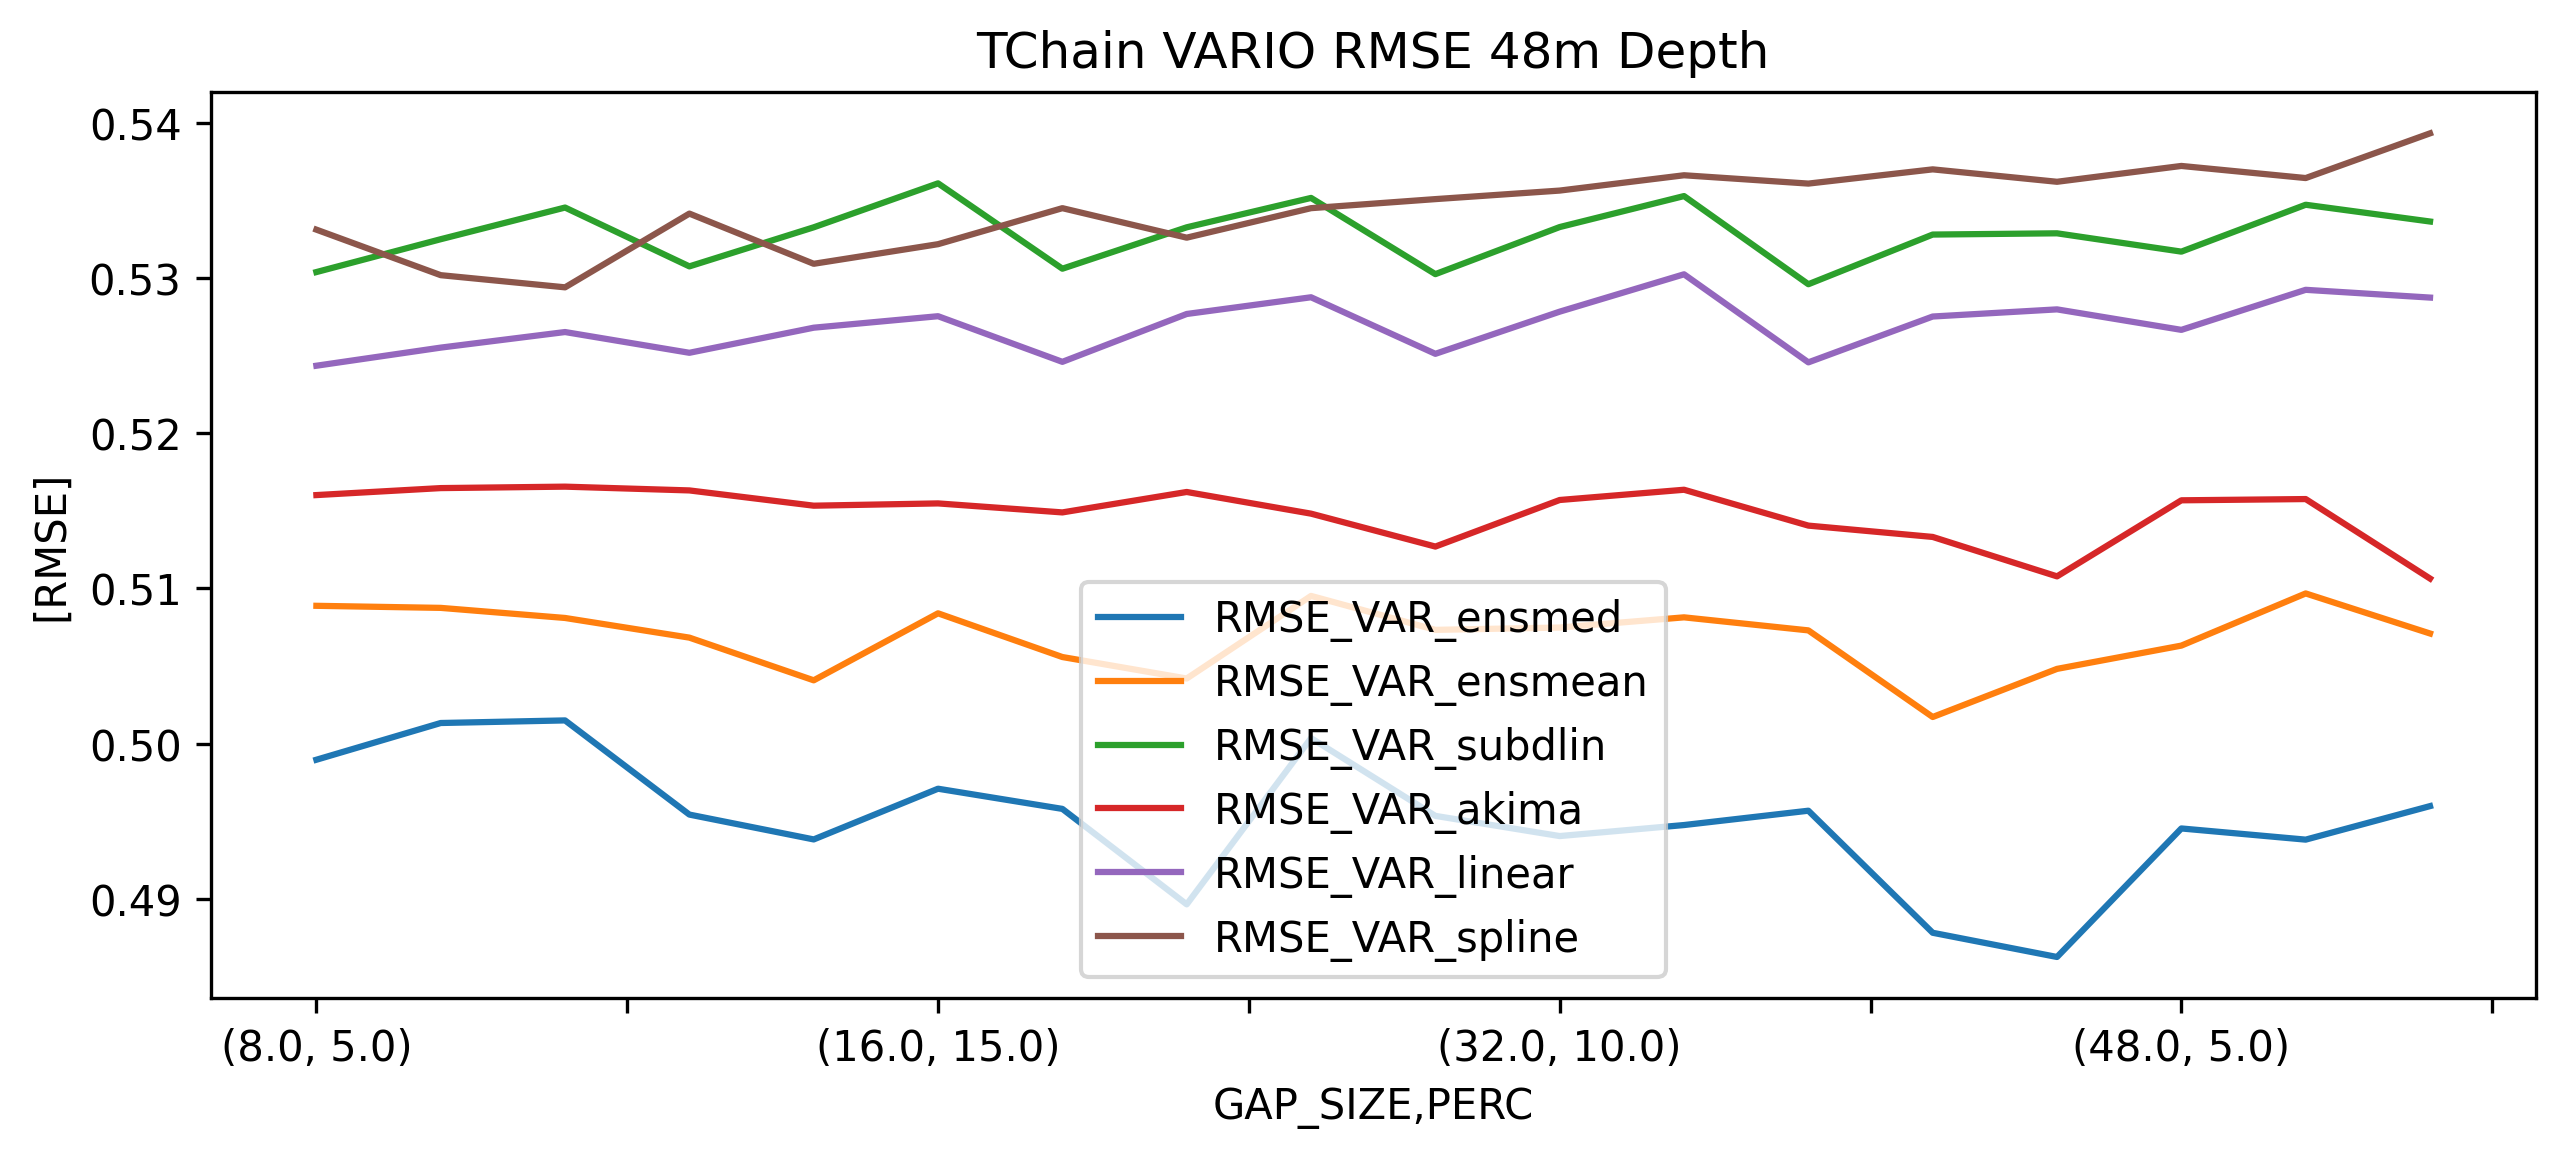

In [16]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
#error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")
error_df[error_df.columns[1:]].where(error_df["DEPTH"]==-48).groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")


plt.legend()
name="TChain VARIO RMSE 48m Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE48.png")

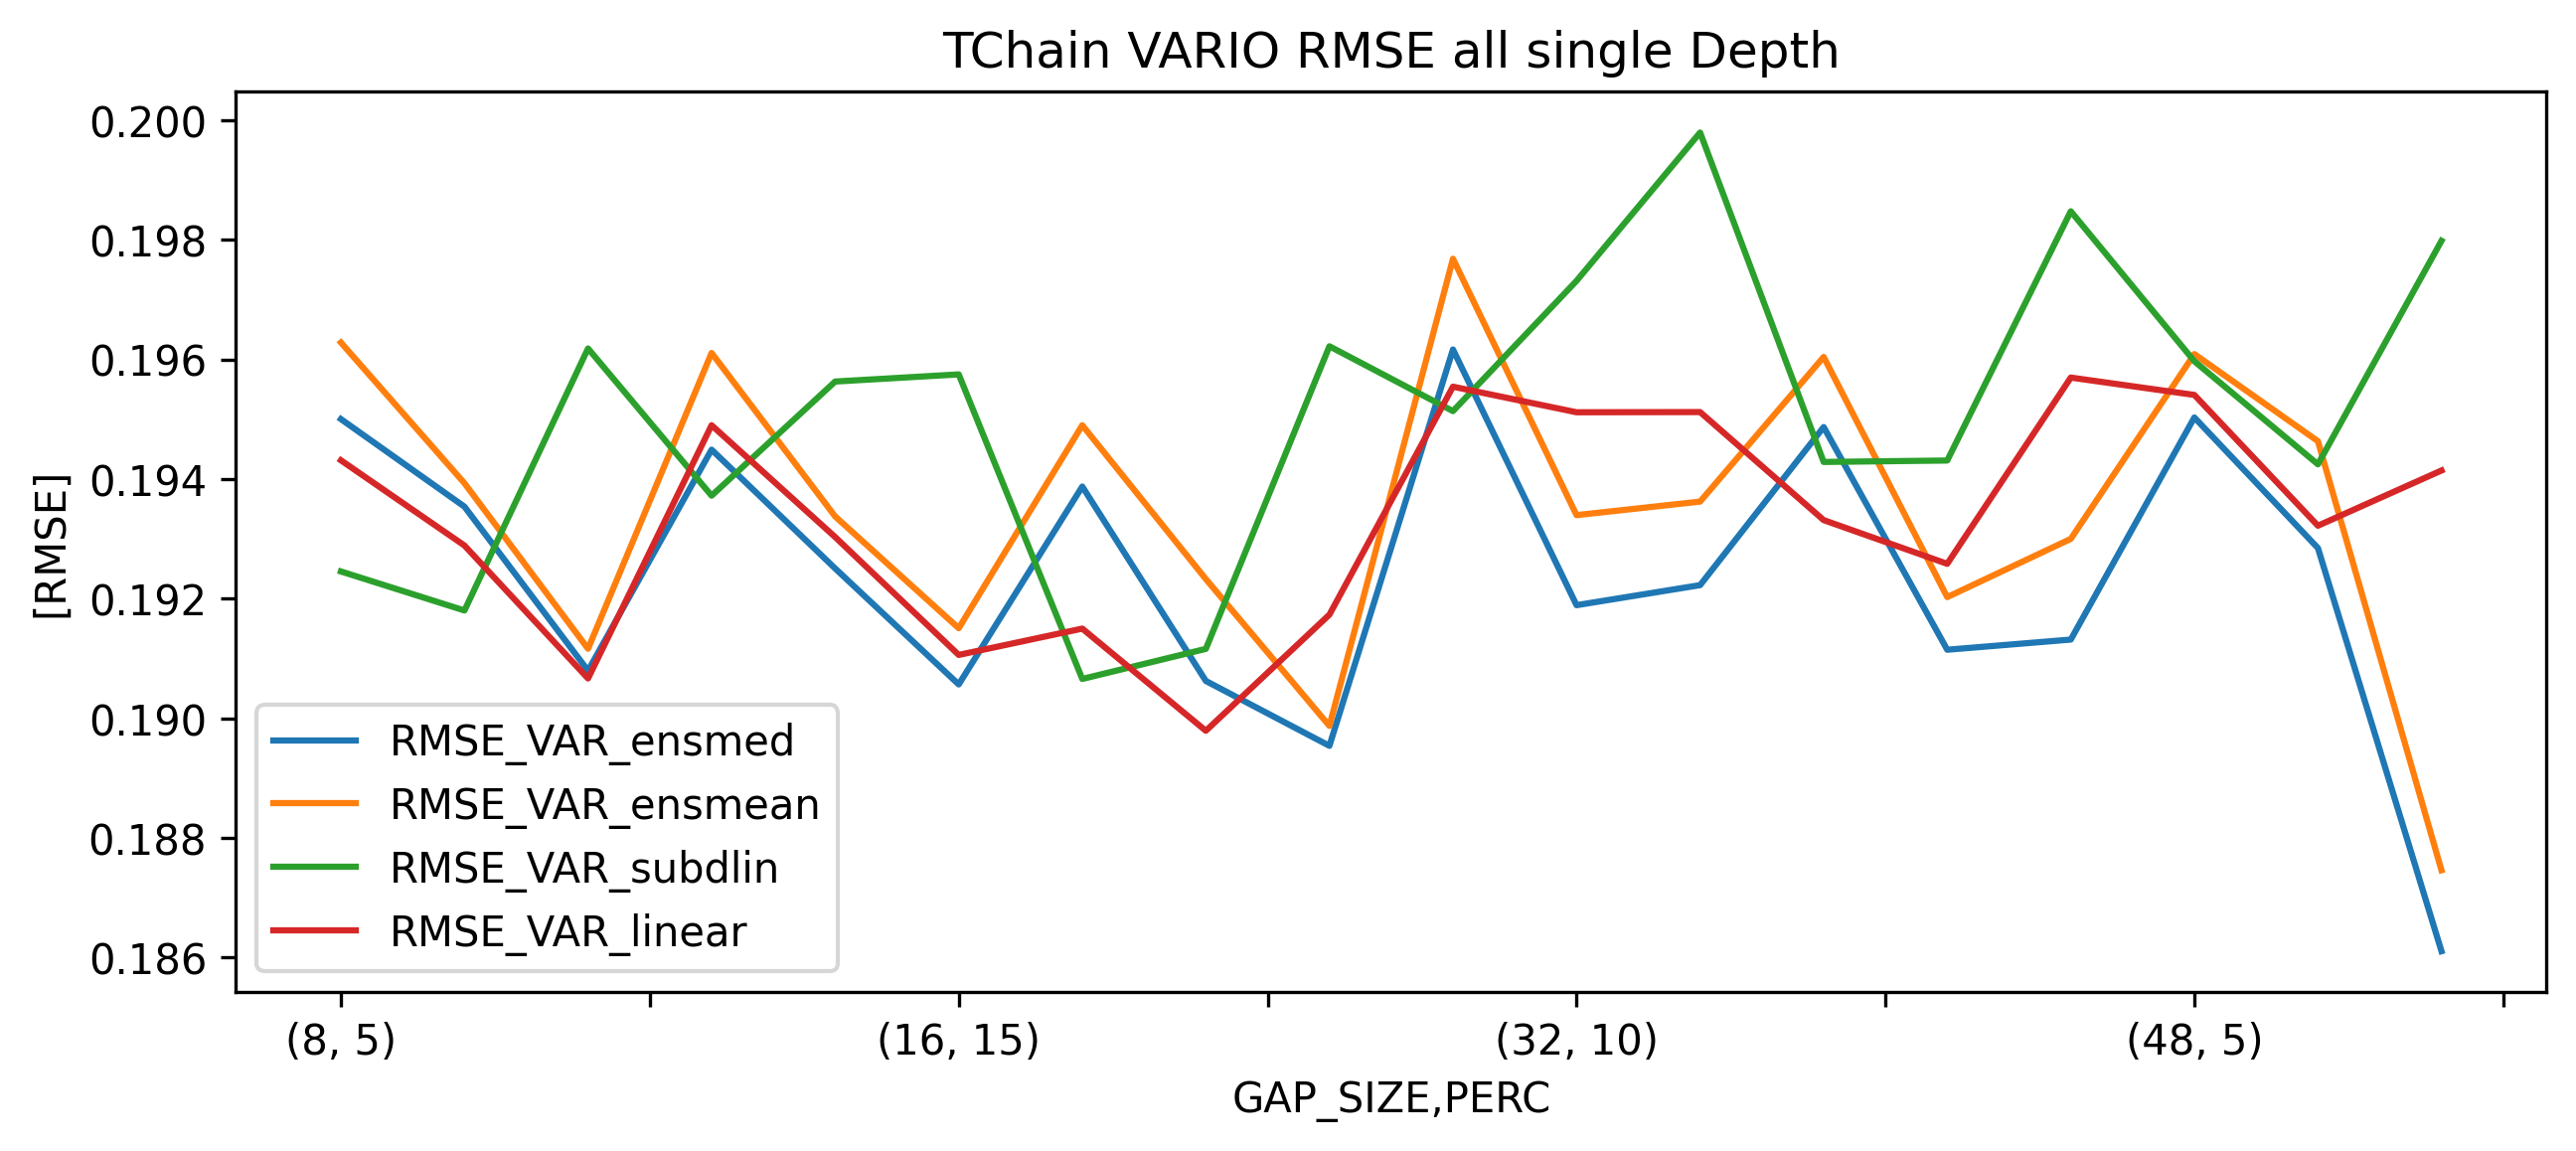

In [27]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.plot(label="RMSE_VAR_linear")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.plot(label="RMSE_VAR_pchip")

plt.legend()
name="TChain VARIO RMSE all single Depth"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSEAS.png")

In [47]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_median.mean()


0.19236376543209877

In [48]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_mean.mean()


0.1934881790123457

In [49]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.mean()


0.19500212962962962

In [50]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.mean()



0.23386972222222221

In [51]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_lin.mean()


0.1932333950617284

In [33]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.mean()


0.22414280864197533

In [52]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().VAR_pchip.mean()


767693.6051235185

In [28]:
error_df=pd.read_csv("/Users/mwegmann/Dropbox/EPFL/tchain_15m_caldaynei_temp.csv")


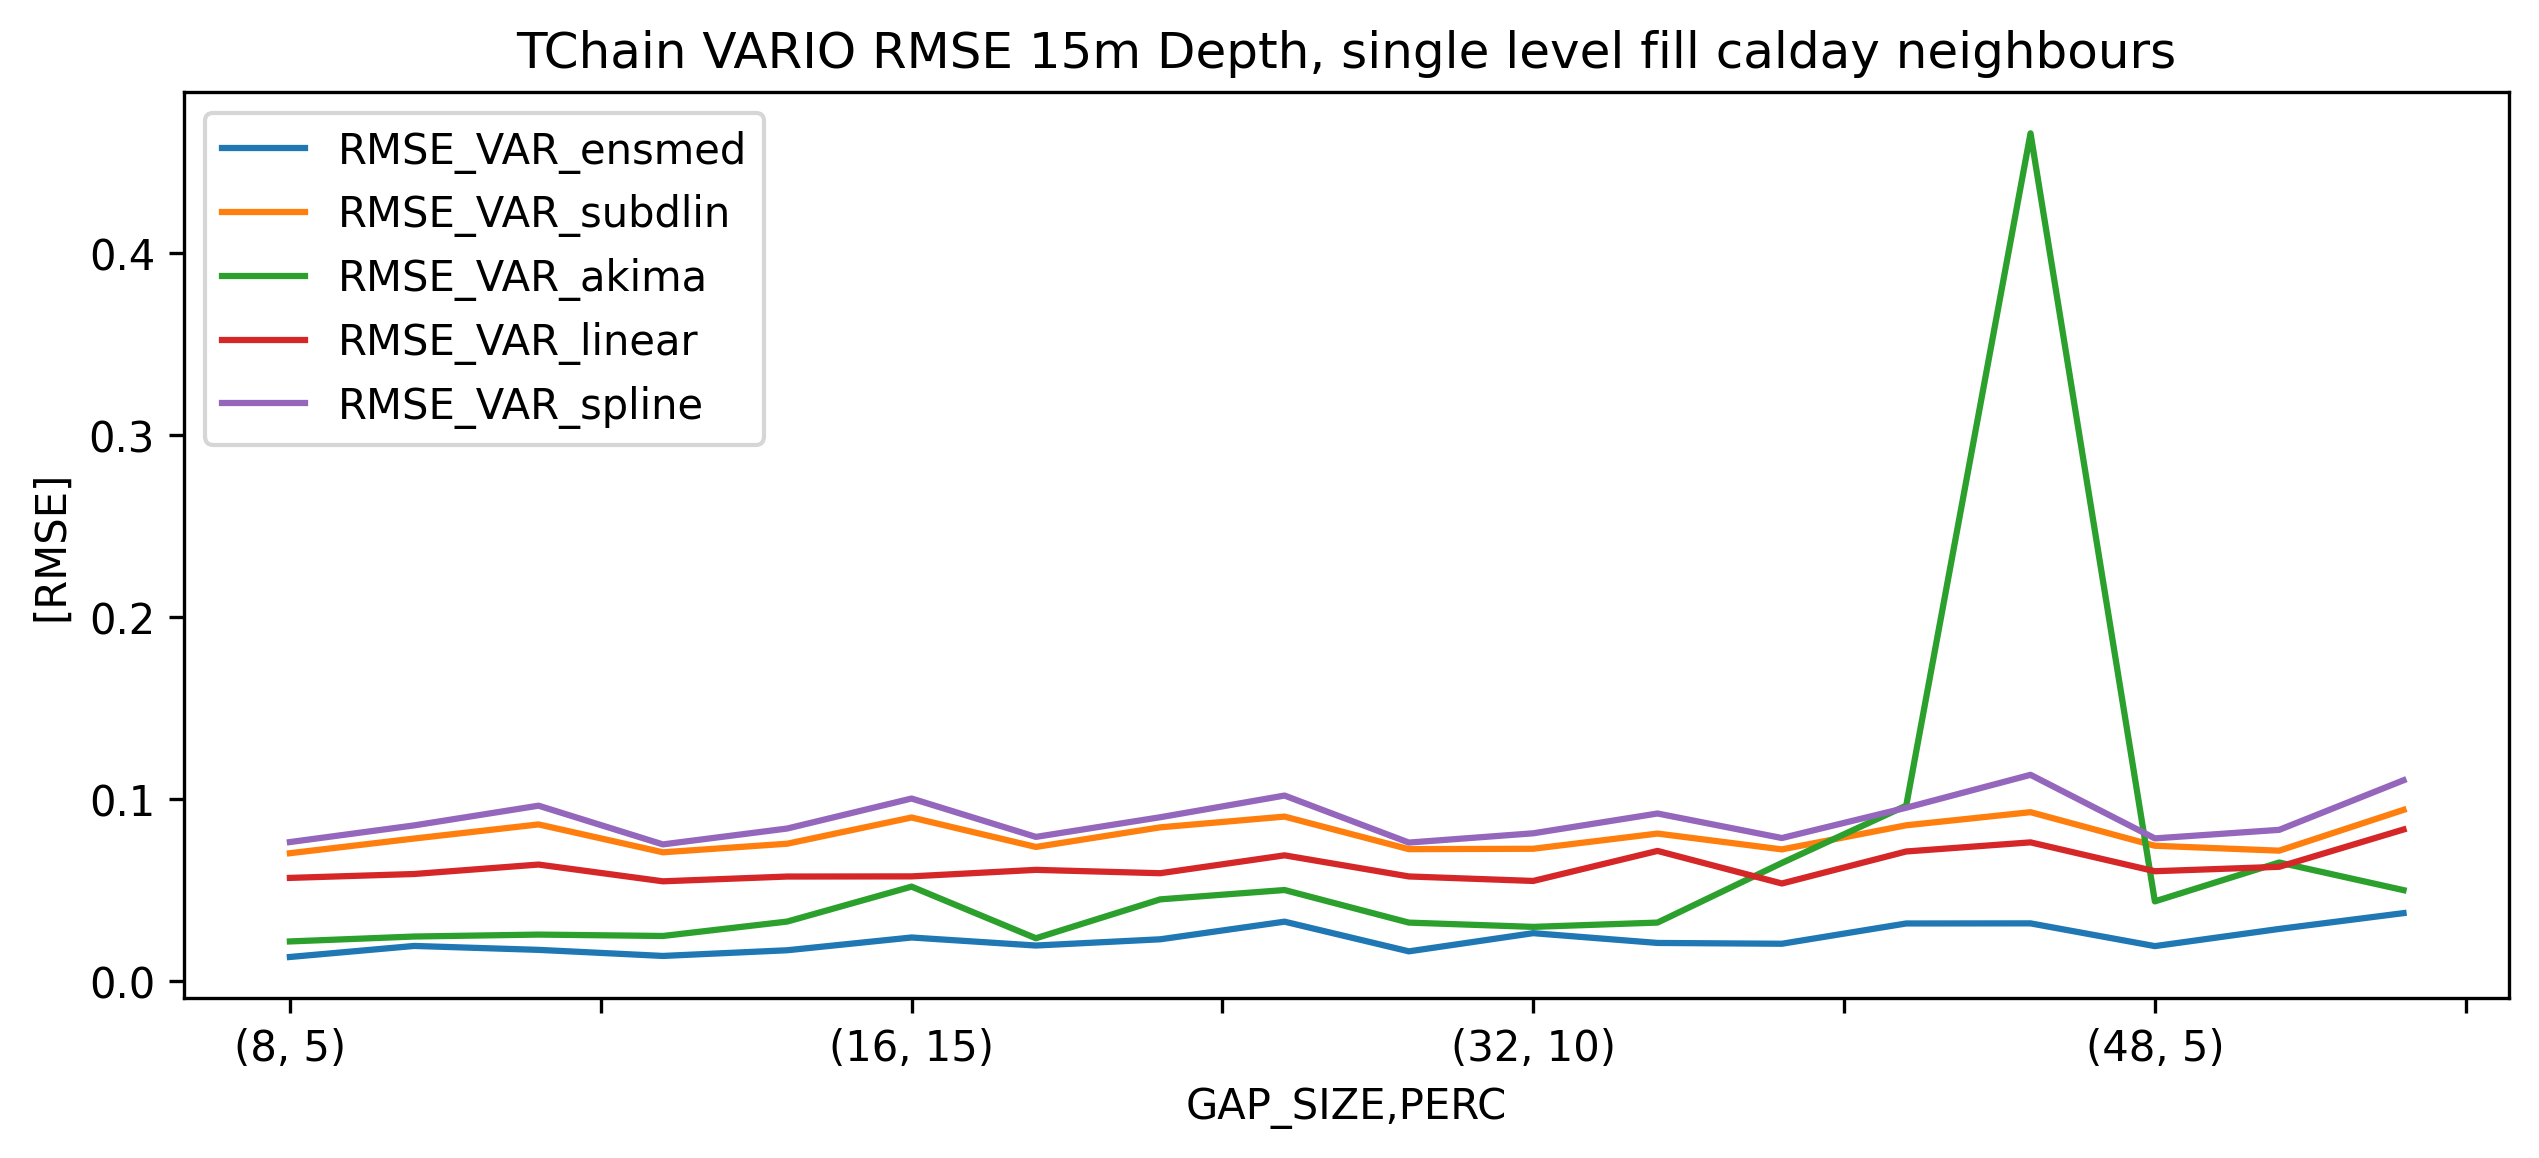

In [29]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmed.plot(label="RMSE_VAR_ensmed")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_linear.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_quad.plot(label="RMSE_VAR_quad")


plt.legend()
name="TChain VARIO RMSE 15m Depth, single level fill calday neighbours"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE_15m_single_level_caldaynei.png")

In [30]:
error_df=pd.read_csv("/Users/mwegmann/Dropbox/EPFL/tchain_15m_nei_temp.csv")


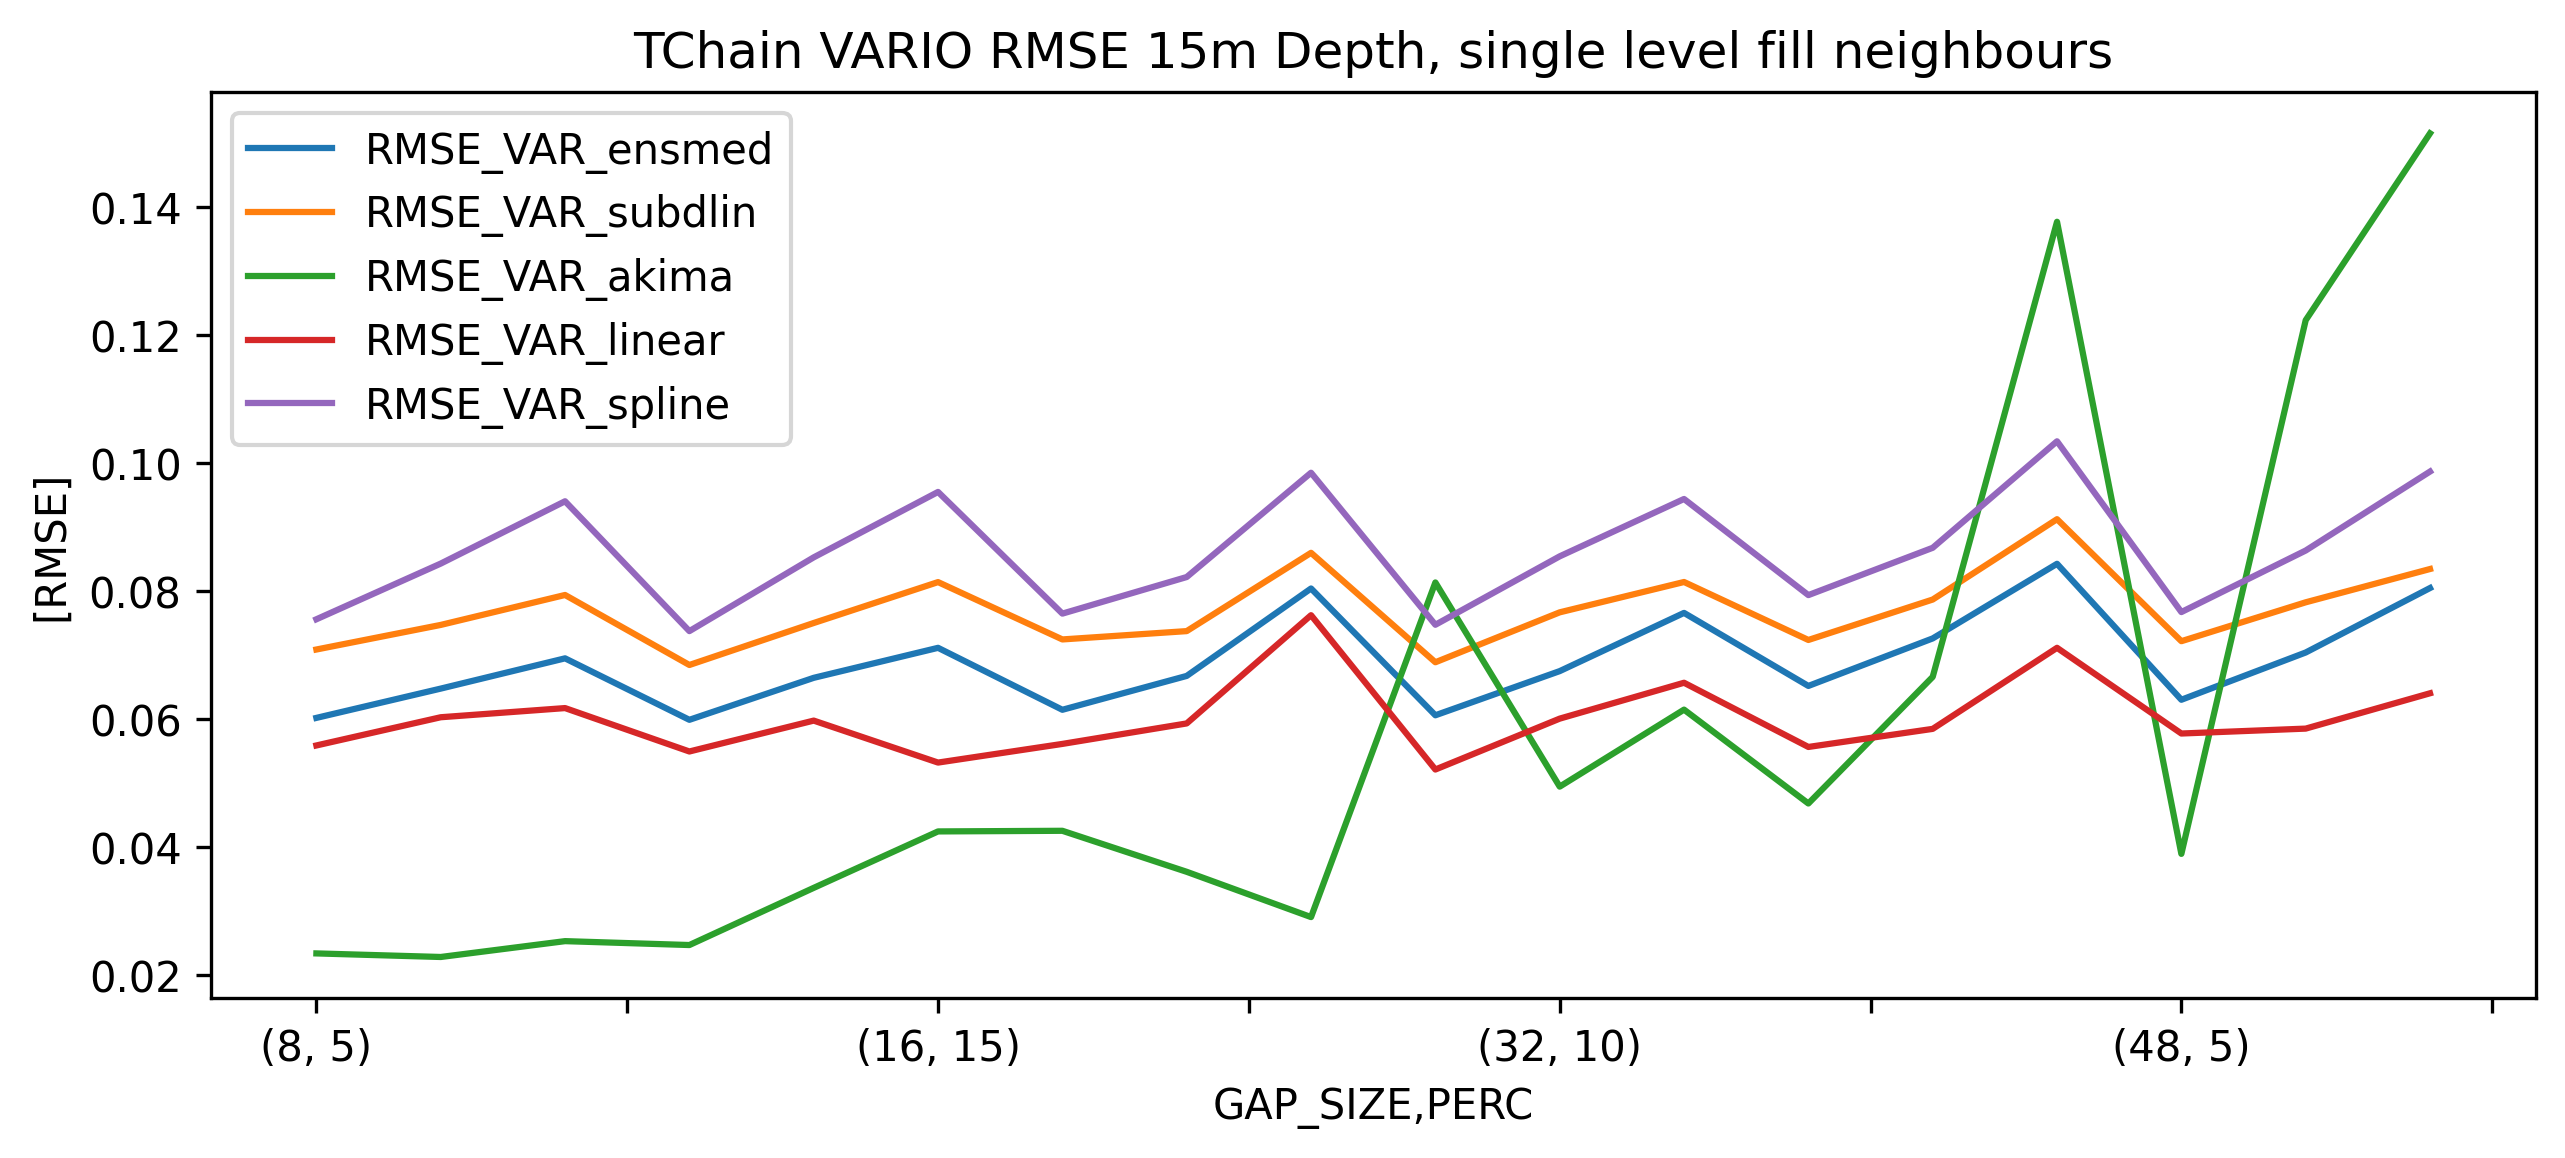

In [31]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmed.plot(label="RMSE_VAR_ensmed")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_linear.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_quad.plot(label="RMSE_VAR_quad")


plt.legend()
name="TChain VARIO RMSE 15m Depth, single level fill neighbours"
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig("/Users/mwegmann/Dropbox/EPFL/TChainVARIORMSE_15m_single_level_nei.png")

In [9]:
error_df=pd.read_csv("/Users/mwegmann/Dropbox/EPFL/tchain_10m_caldaynei_temp.csv")


Text(0.5, 1.0, 'variability_RMSE_temp')

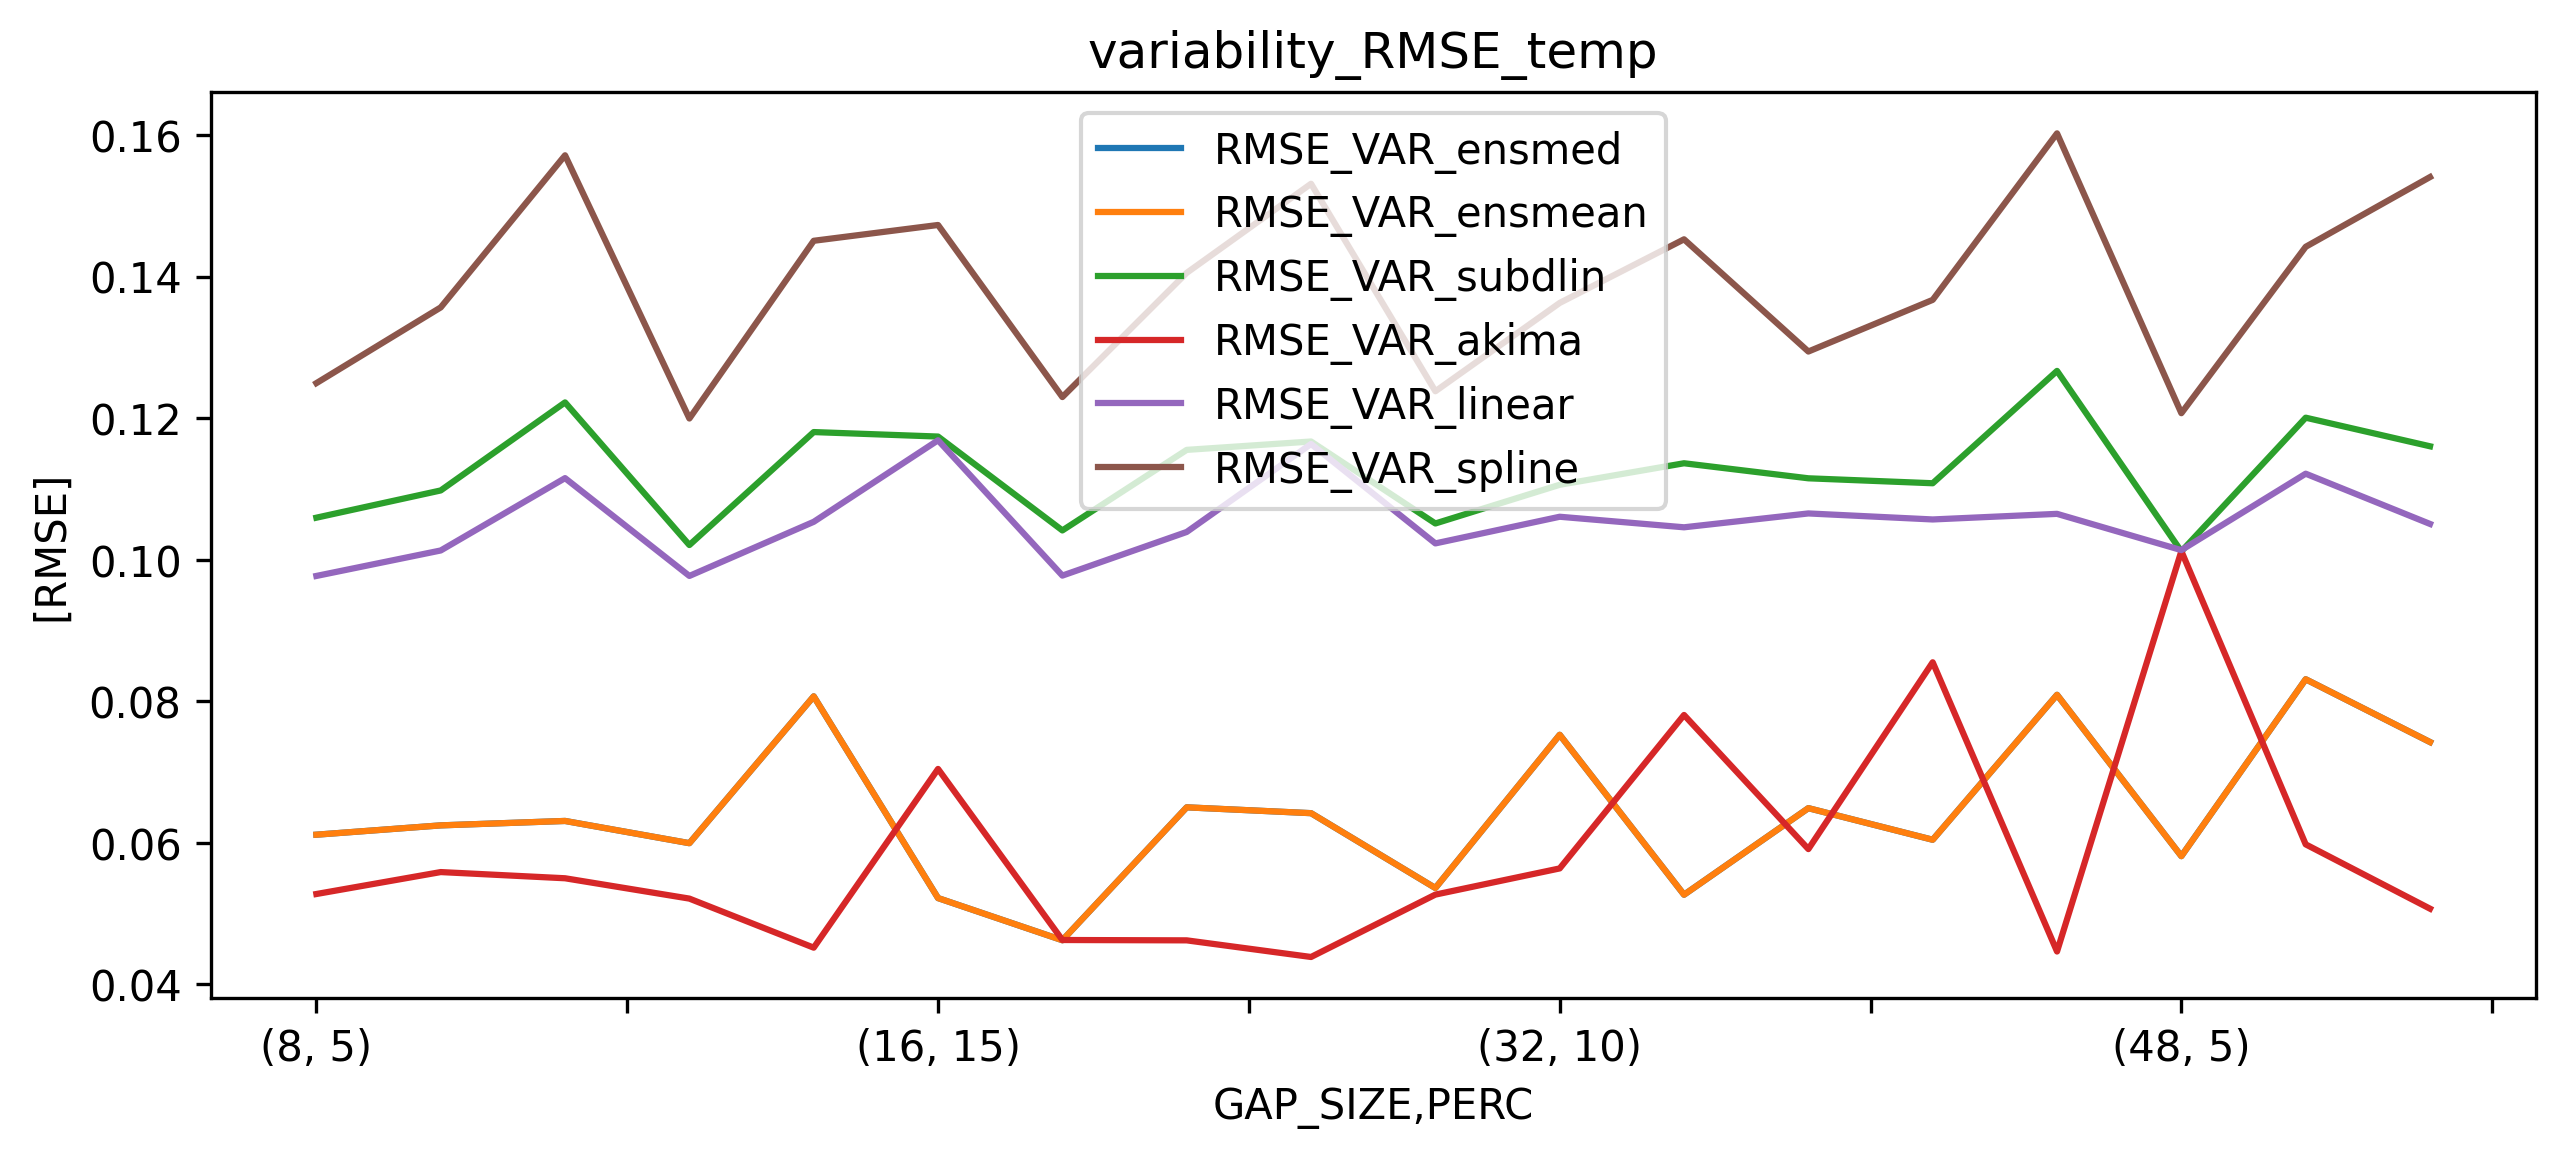

In [10]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmed.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_linear.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_quad.plot(label="RMSE_VAR_quad")


plt.legend()
name="variability_RMSE_temp"
plt.ylabel("[RMSE]")
plt.title(name)


In [11]:
error_df=pd.read_csv("/Users/mwegmann/Dropbox/EPFL/tchain_10m_nei_temp.csv")


Text(0.5, 1.0, 'variability_RMSE_temp')

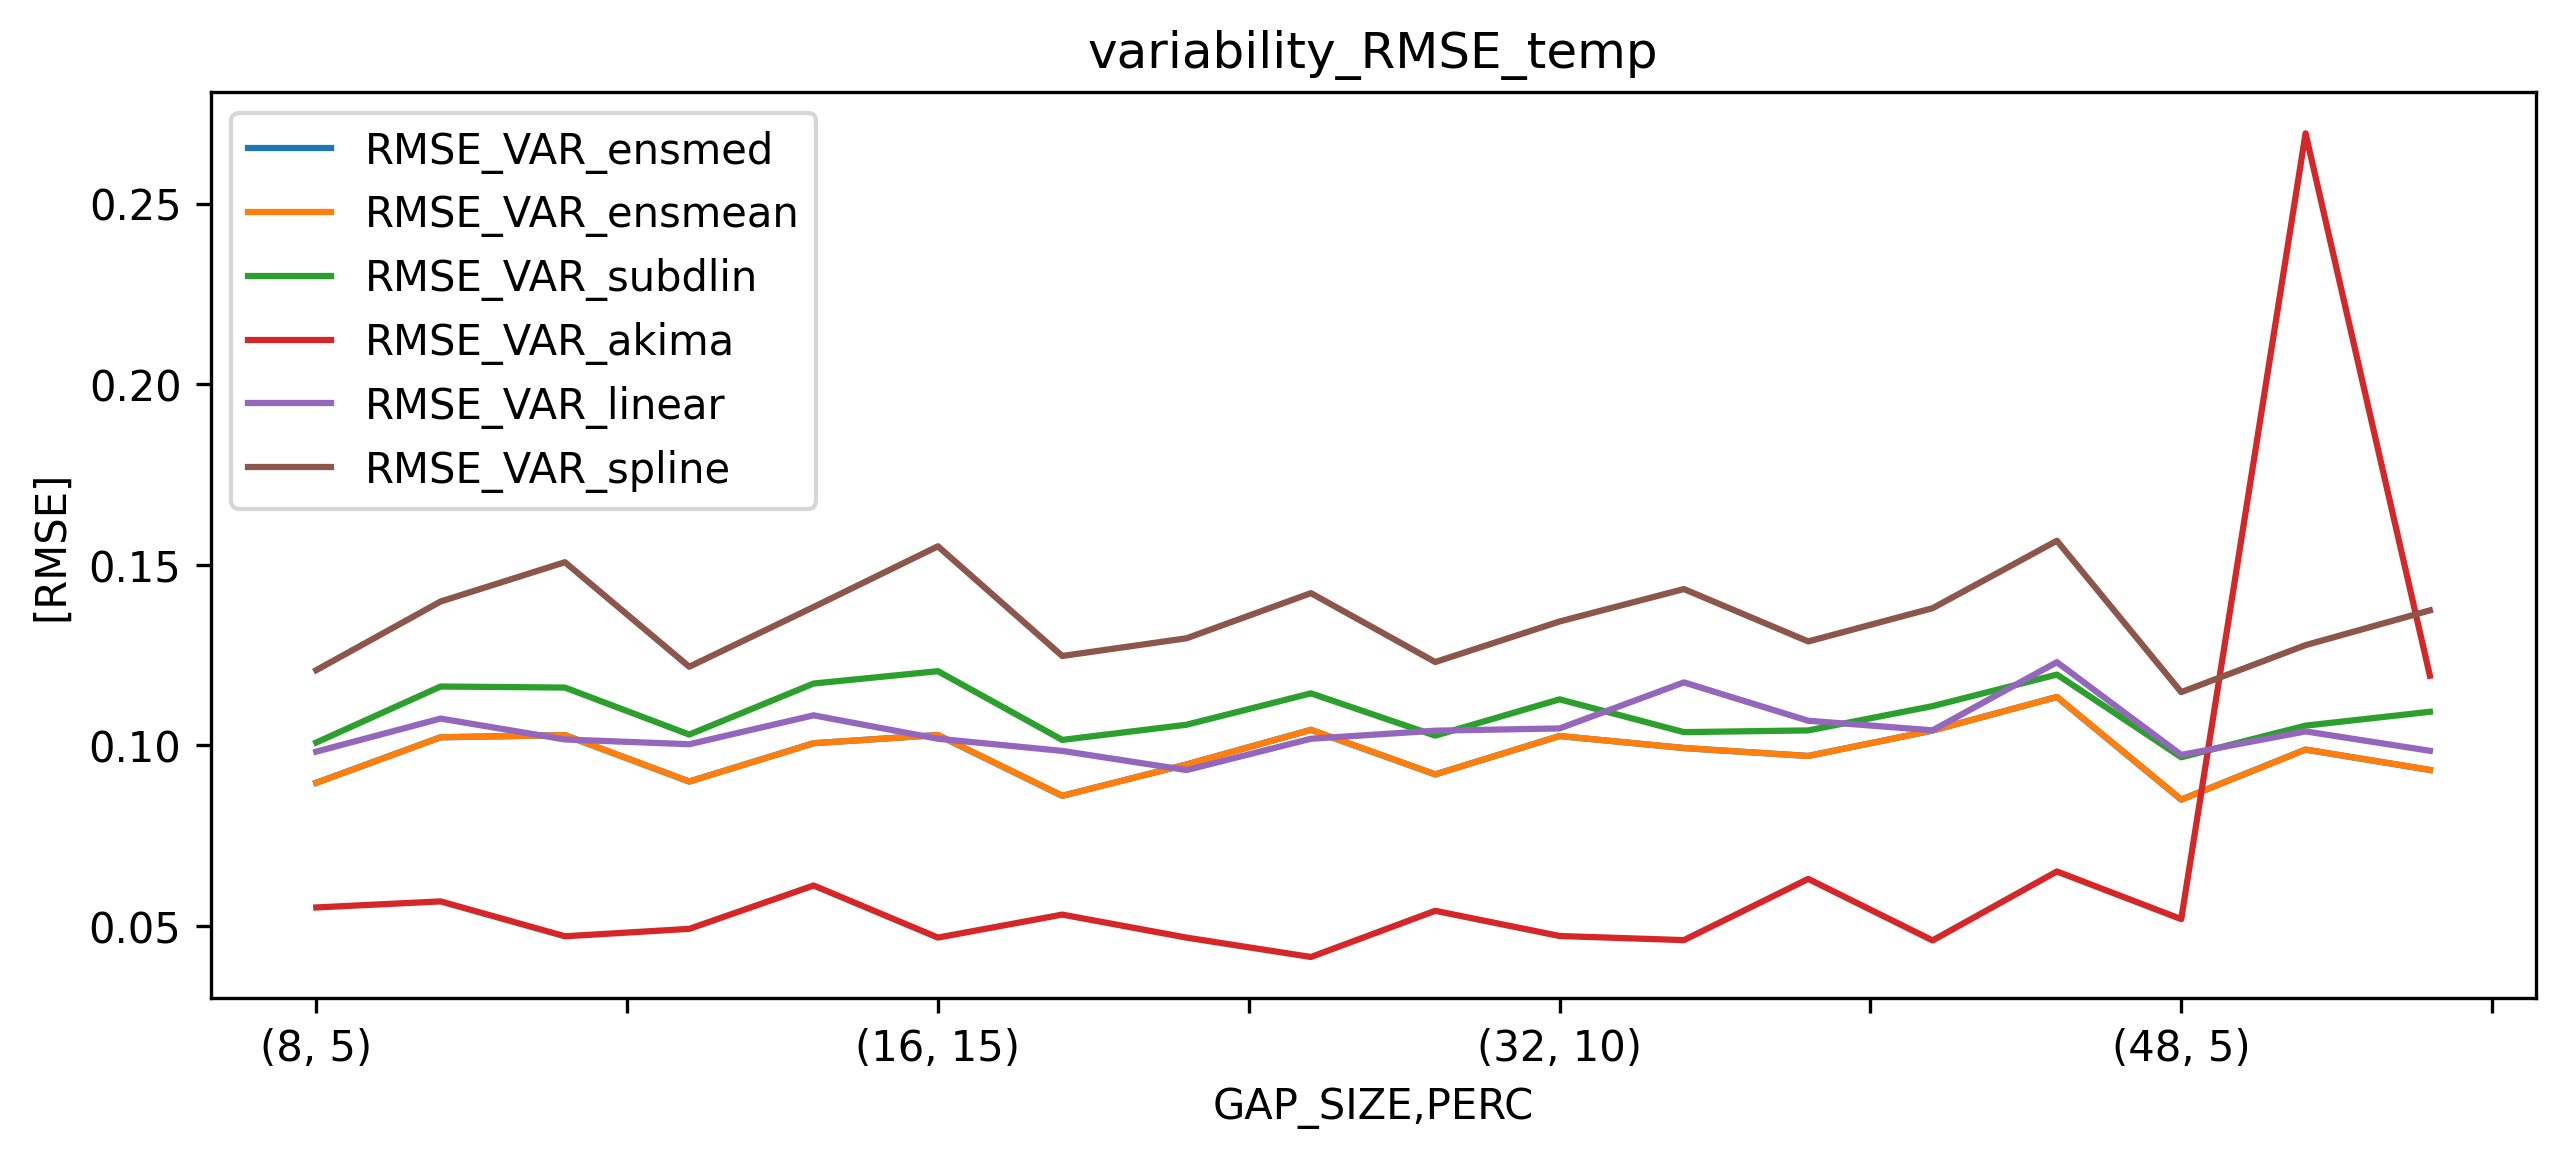

In [14]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmed.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_linear.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_spline.plot(label="RMSE_VAR_spline")
#error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_quad.plot(label="RMSE_VAR_quad")


plt.legend()
name="variability_RMSE_temp"
plt.ylabel("[RMSE]")
plt.title(name)


#### reconstruction phase

In [ ]:
N=50

## Fill Idronaut Temp Data

In [ ]:
varname="temp"


In [ ]:
gap_info(var=idronaut[varname],varname="idronaut_temp",plot_folder=plots_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[8,16,24]
selector_list=[1,2,3]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)



In [ ]:
 # you have to use the var profile from tchain

In [ ]:
filled_data,error_df=day_of_year_g2s_2D(original=tchain,var=varname,obs_in_day=timestepsinday,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="tchain_eval_",depan="var")